In [1]:
#Загружаем библиотеки
import seaborn as sns
import tensorflow as tf
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout,Dense, TimeDistributed, Input, RepeatVector
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed


In [2]:
#функция считывает названия параметров из файла и приводит в вид для считывания
def process_excel_headers(excel_file):
  """
  Обрабатывает заголовки столбцов в Excel-файле.

  Args:
      excel_file (str): Путь к Excel-файлу.
      sheet_name (str): Название листа в Excel-файле.

  Returns:
      tuple: Кортеж из трех списков:
          - Исходные заголовки столбцов.
          - Заголовки столбцов без первого элемента.
          - Список обновленных заголовков с префиксом и суффиксом "ssx".
  """
  df = pd.read_csv(excel_file)

  fileheaders = list(df.columns)
  fileheaders  = [header.lower() for header in fileheaders]
  headerskey = fileheaders[1:]
  updated_list = ["ssx" + item for item in headerskey]
  jsonstring = str(updated_list)
  jsonstring = jsonstring.replace("'", '"')    
  return fileheaders, headerskey, updated_list, jsonstring
excel_file = 'cached_data_8.csv'
sheet_name = 'BasicDatasetSteamTurbine'
fileheaders, headerskey, updated_list, jsonstring = process_excel_headers(excel_file)

type(fileheaders)

In [3]:
fileheaders

['ssx10mag10cp930',
 'ssx10pab20ct001',
 'ssx10pab10ct001',
 'ssxtg_2ce003',
 'ssx10lca10ct001',
 'ssx10pab10cf001',
 'ssx10lbg11cp920',
 'ssx10lbg40cp920',
 'ssx10pab60ct001',
 'ssx10pab30ct001',
 'ssx10maa01cp001',
 'ssx10lca20cf001',
 'ssx10maa01ct001',
 'ssx10pab30cf001',
 'datetime']

In [3]:
#определяем размер будущего графика и убираем сетку (если False)
mpl.rcParams['figure.figsize'] = (10, 12)
mpl.rcParams['axes.grid'] = False

C:\Users\PC\AppData\Local\Temp\ipykernel_13492\3681344862.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['DateTime'] = pd.to_datetime(df['DateTime'], infer_datetime_format=True)


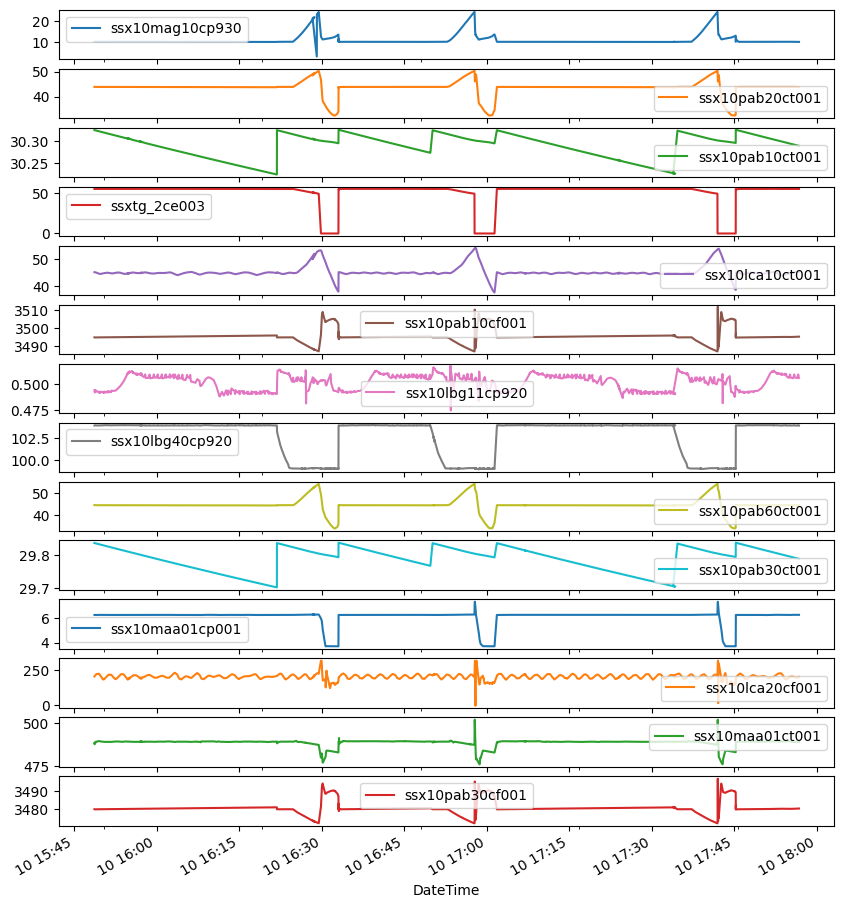

In [4]:
df = pd.read_csv('data_8_without_duplicates.csv')

#делим датасет на слайсы для построения релевантного графика
#df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M')
# Делим датасет на слайсы для построения релевантного графика
#df = df[:int(len(df) * 0.8)]  # Берем для тренировки 80% датасета
#переводит в формат дататайм
df['DateTime'] = pd.to_datetime(df['DateTime'], infer_datetime_format=True)
train_date = pd.to_datetime(df['DateTime'])
df.set_index('DateTime')[['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001']].plot(subplots=True)

df_input = df[['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001']]
#scaler = MinMaxScaler()
#применяем метод масштабирования данных
#применяем метод масштабирования данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_input)

features = data_scaled
target = data_scaled[:,0]

TimeseriesGenerator(features,target,length=2,sampling_rate=1,batch_size=1)[0]

x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.20, random_state=123,shuffle=False)

cols = list(df_input)
df_for_training = df[cols].astype(float)
cols,df_for_training

# Обучаем scaler на обучающей выборке
scaler = scaler.fit(df_for_training)

# Масштабируем обучающую выборку
df_for_training_scaled = scaler.transform(df_for_training)

trainX = []
trainY = []

#делим датасет на ту часть, которую берем для предсказывания и ту, которую будем предсказывать
n_future = 60
n_past = 180

for i in range(n_past, len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i+n_future-1:i+n_future,9])

trainX, trainY = np.array(trainX),np.array(trainY)
# Создаем testX для предсказаний (20% датасета)
testX = []
for i in range(len(df_for_training_scaled) - int(len(df_for_training_scaled) * 0.2) - n_past, len(df_for_training_scaled)-n_future+1):
    testX.append(df_for_training_scaled[i-n_past:i, 0:df_for_training.shape[1]])


# Создаем testY для предсказаний (20% датасета)
testY = []
for i in range(len(df_for_training_scaled) - int(len(df_for_training_scaled) * 0.2) - n_past, len(df_for_training_scaled)-n_future+1):
    testY.append(df_for_training_scaled[i+n_future-1:i+n_future,9])

testY = np.array(testY)
testX = np.array(testX)



c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 180, 64)        │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - loss: 42102476.0000 - val_loss: 1.1467
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - loss: 2262.4585 - val_loss: 224178464.0000
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: nan - val_loss: nan
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: nan - val_loss: nan
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: nan - val_loss: nan
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: nan - val_loss: nan
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: nan - val_loss: nan
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: nan - val_loss: nan
Epoch 9/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: nan - val_loss: nan
Epoch 10/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: nan - val_loss: nan
Epoch 11/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: nan - val_loss: nan
Epoch 12/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: nan - val_loss: nan
Epoch 

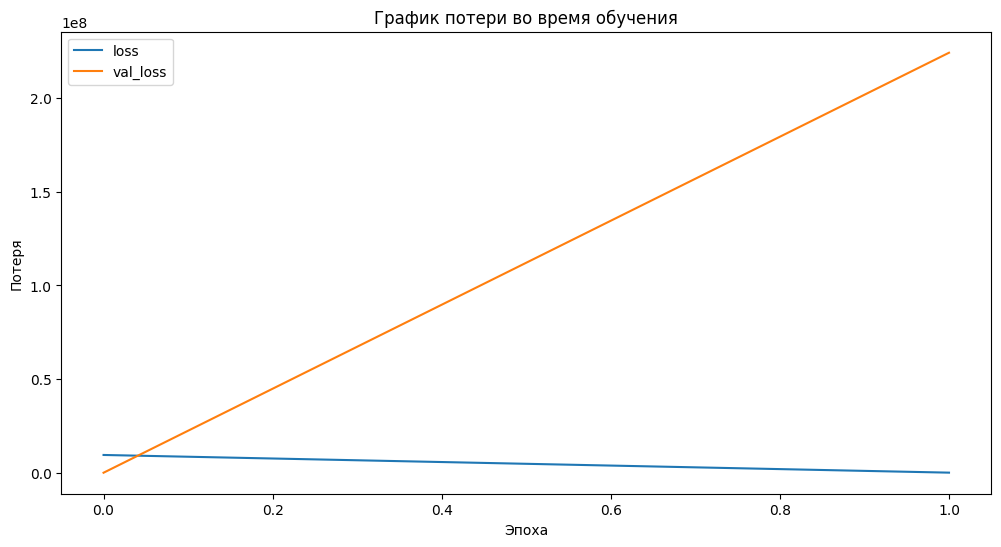

In [5]:
#модель lstm
model_lstm2 = Sequential()
model_lstm2.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)) 
model_lstm2.add(LSTM(32, activation='relu', return_sequences=False))  # Wrap the second LSTM
model_lstm2.add(Dropout(0.2))
model_lstm2.add(Dense(trainY.shape[1]))

# Компиляция модели с оптимизатором Adam, функцией потерь MSE
model_lstm2.compile(optimizer='adam', loss='mae')

# Вывод структуры модели
model_lstm2.summary()
    
# Обучение модели на тренировочных данных
# epochs: количество эпох обучения
# batch_size: размер выборки для обучения
# validation_split: доля данных для валидации
# verbose: уровень детализации вывода информации
history = model_lstm2.fit(trainX, trainY, epochs = 30, batch_size = 64, validation_split = 0.3, verbose = 1)

# Получение данных о потере и точности с истории обучения
#значение 
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(12, 6))
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('График потери во время обучения')
plt.legend()

plt.show()
 

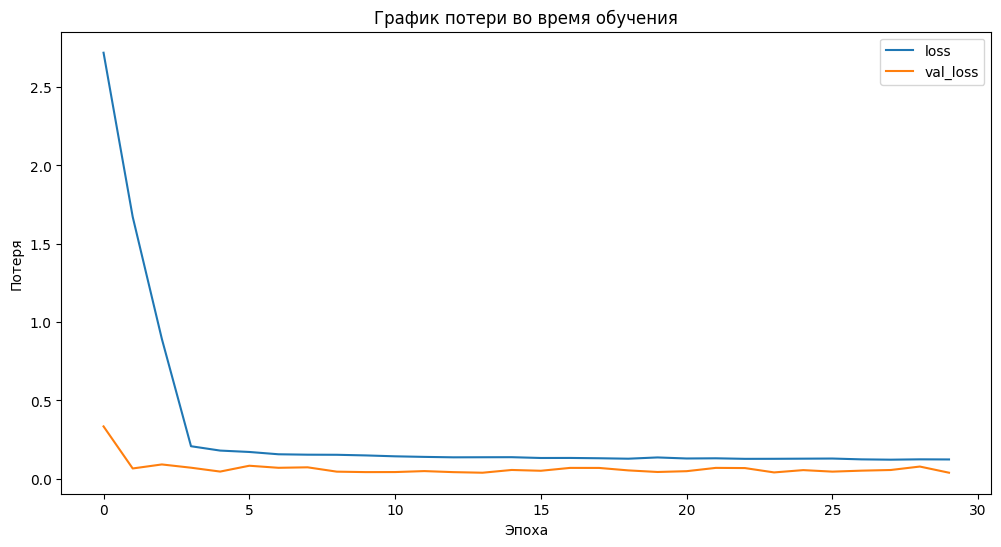

In [26]:

plt.figure(figsize=(12, 6))
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('График потери во время обучения')
plt.legend()

plt.show()
 

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


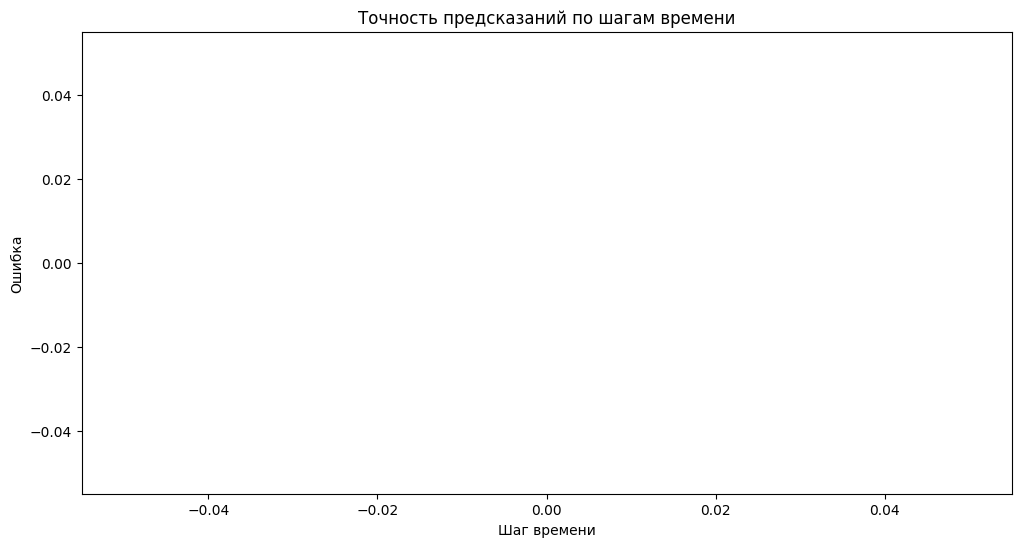

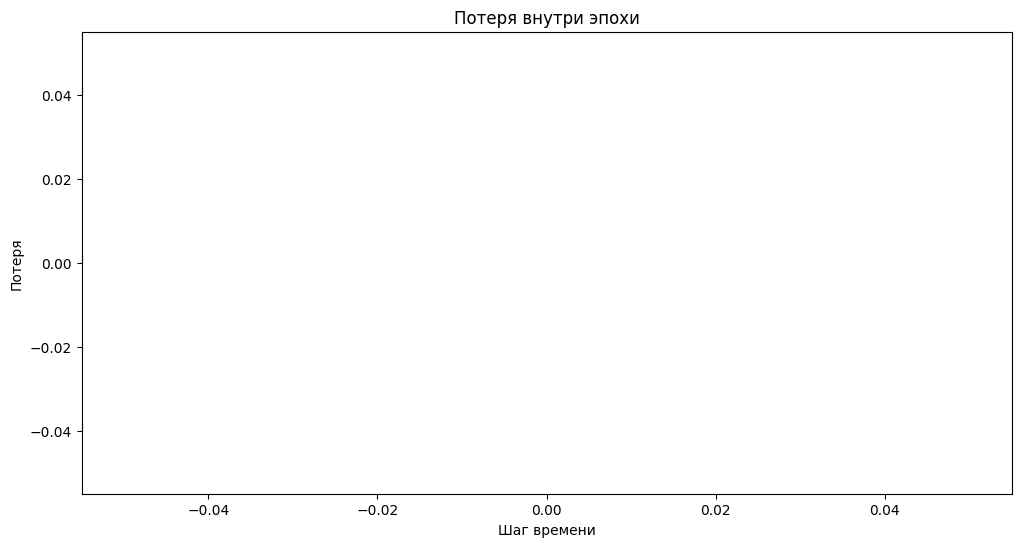

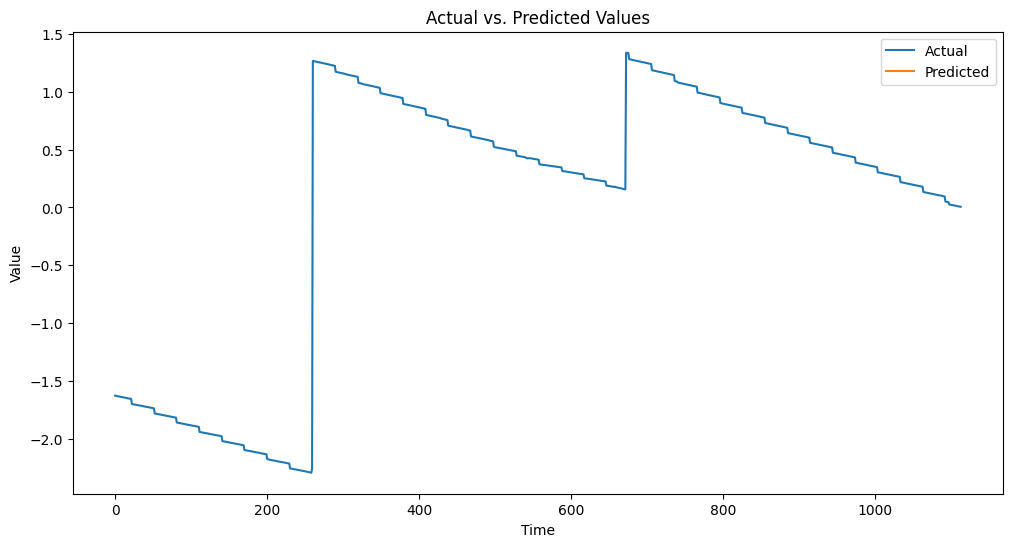

In [6]:

test_predict = model_lstm2.predict(testX)

error = np.mean((test_predict - testY), axis=1)
# Создание графика
loss = np.mean((test_predict - testY) ** 2, axis=1)
# Построить график ошибки по отношению к шагам времени

plt.figure(figsize=(12, 6))
plt.plot(error)
plt.xlabel('Шаг времени')
plt.ylabel('Ошибка')
plt.title('Точность предсказаний по шагам времени')
plt.show()


# Рисуем график потери по отношению к шагам времени
plt.figure(figsize=(12, 6))
plt.plot(loss)
plt.xlabel('Шаг времени')
plt.ylabel('Потеря')
plt.title('Потеря внутри эпохи')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(testY, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()



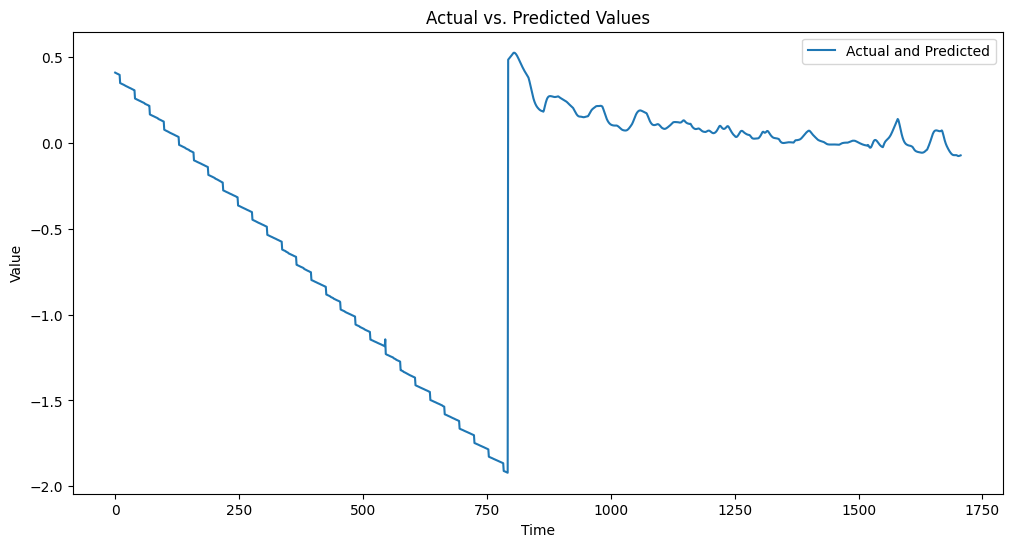

In [42]:
# Создаем массив с реальными значениями и предсказанными значениями
real_and_predicted = np.append(df_for_training_scaled[-int(len(df_for_training_scaled) * 0.2):,9], test_predict)

# Рисуем график реальных и предсказанных значений
plt.figure(figsize=(12, 6))
plt.plot(real_and_predicted, label='Actual and Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()



In [5]:
#подгоняем формат даты для дальнейших манипуляций
# Проверяем, есть ли столбец 'Date Time' в датафрейме
if 'DateTime' in df.columns:
    date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)
else:
    print("Столбец 'DateTime' отсутствует в датафрейме.")

C:\Users\PC\AppData\Local\Temp\ipykernel_6988\367553521.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)


In [6]:
TOTAL = df.shape[0]
TRAIN_VAL = int(TOTAL * 0.5)
VAL_TEST = int(TOTAL * 0.7)


my_scaler = MinMaxScaler()
df_scaled = my_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)
train_df = df[:TRAIN_VAL]
val_df = df[TRAIN_VAL:VAL_TEST]
test_df = df[VAL_TEST:]

print("Training dataset shape:", train_df.shape)
print("Validation dataset shape:", val_df.shape)
print("Test dataset shape:", test_df.shape)

Training dataset shape: (1984, 14)
Validation dataset shape: (794, 14)
Test dataset shape: (1191, 14)


C:\Users\PC\AppData\Local\Temp\ipykernel_6988\2666552140.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


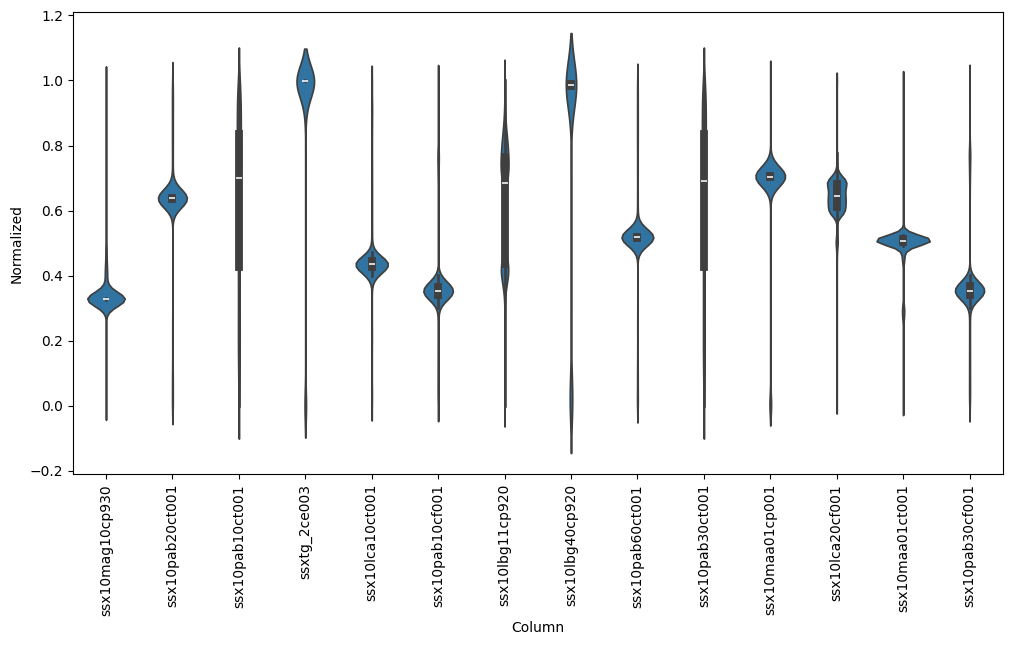

In [7]:
df_std = df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [13]:
INPUT_TIMES = 72
OUTPUT_TIMES = 24
# Single step dataset preparation
def multiStepSampler(df, window_input=INPUT_TIMES, window_output=OUTPUT_TIMES):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window_input - window_output):
		xRes.append(df.iloc[i:i + window_input].values)
		yRes.append(df.iloc[i + window_input:i + window_input + window_output].values)
	return np.array(xRes), np.array(yRes)


In [15]:
# Dataset splitting
(X_train, y_train) = multiStepSampler(train_df)
(X_val, y_val) = multiStepSampler(val_df)
(X_test, y_test) = multiStepSampler(test_df)

OUT_STEPS = 24

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result



def plot(self, model=None, plot_col='ssx10mag10cp930', max_subplots=1):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

  
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.plot = plot
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1] * y_train.shape[2],
                                            activation='linear', kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([y_train.shape[1], y_train.shape[2]])
])
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=[tf.keras.metrics.MeanAbsoluteError()])



history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    shuffle=False
)
IPython.display.clear_output()

lstm_model.summary()


multi_val_performance = {}
multi_performance = {}

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 336)            │        33,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 24, 14)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,810 (936.76 KB)

 Trainable params: 79,936 (312.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 159,874 (624.51 KB)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0092 - mean_absolute_error: 0.0611 


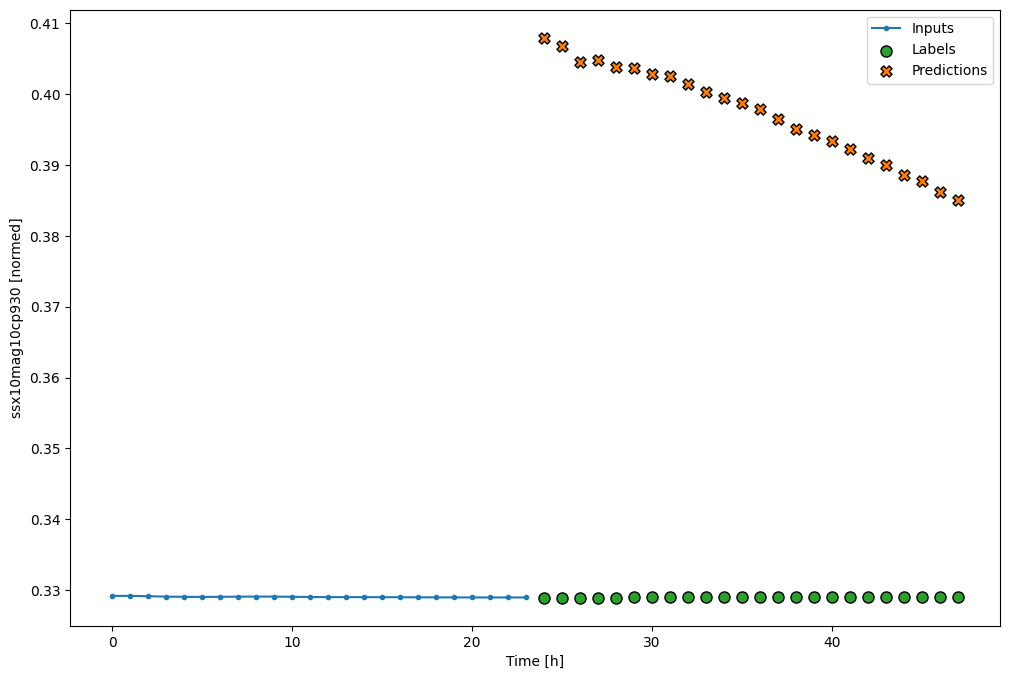

In [11]:
multi_val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(lstm_model)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


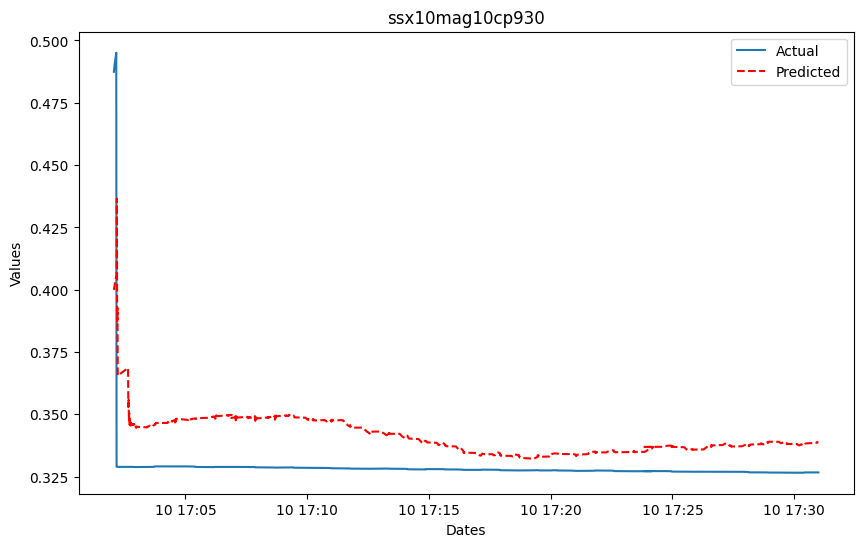

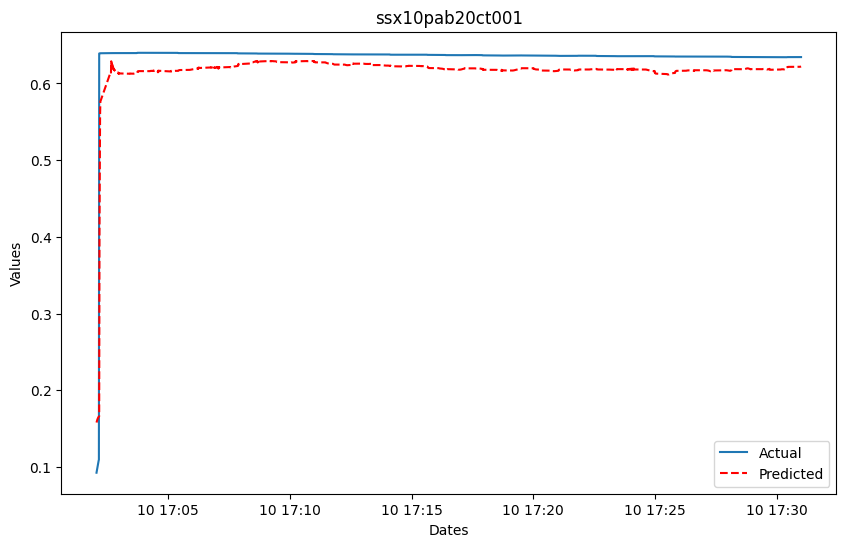

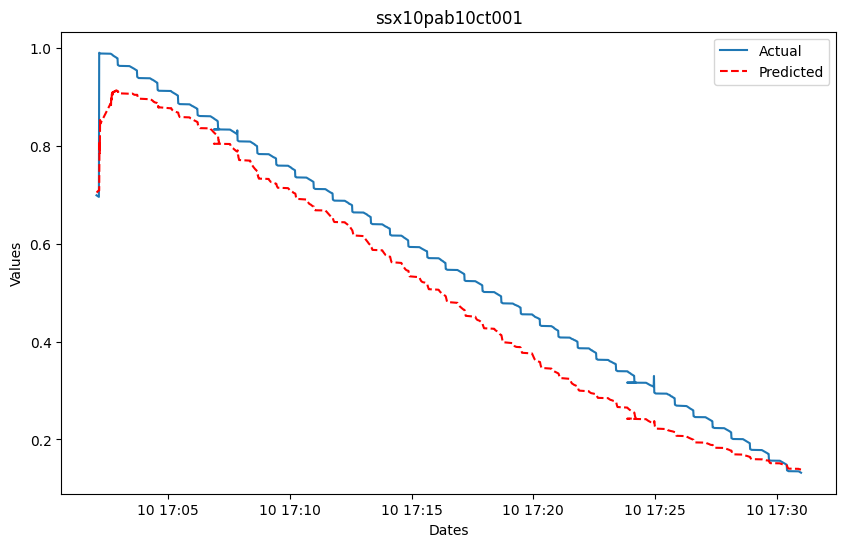

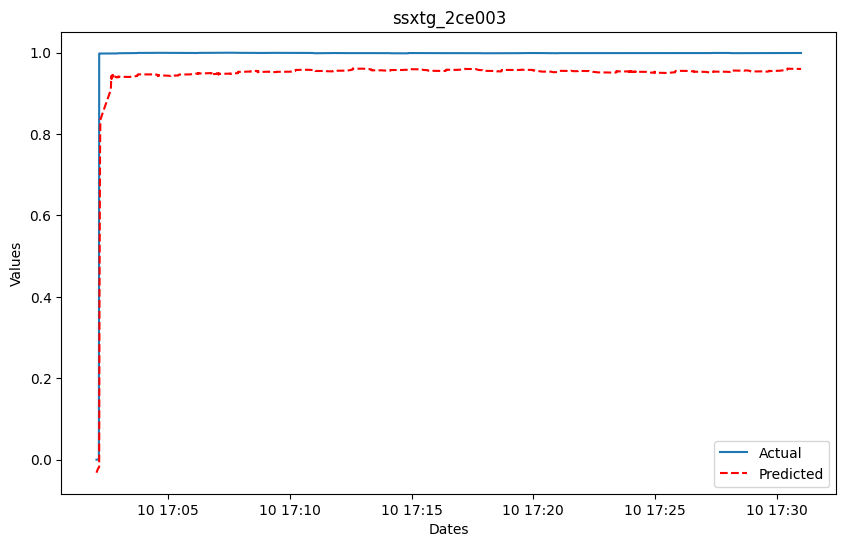

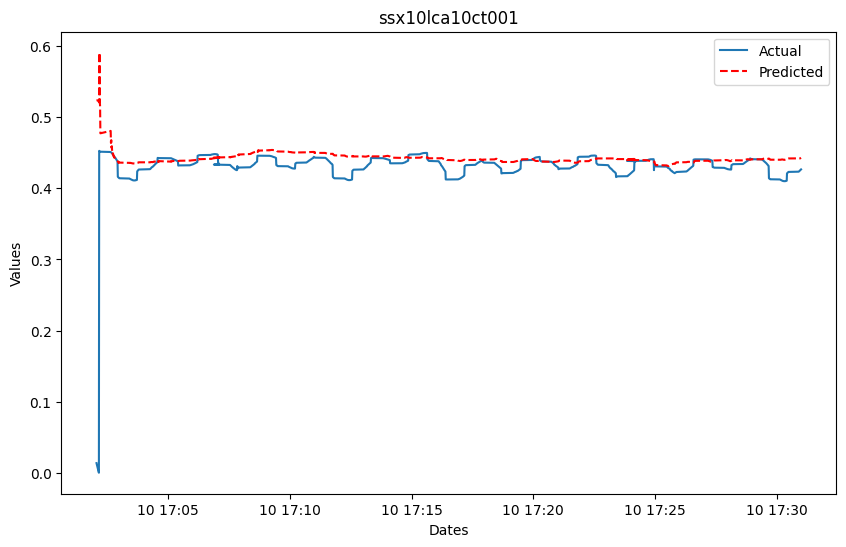

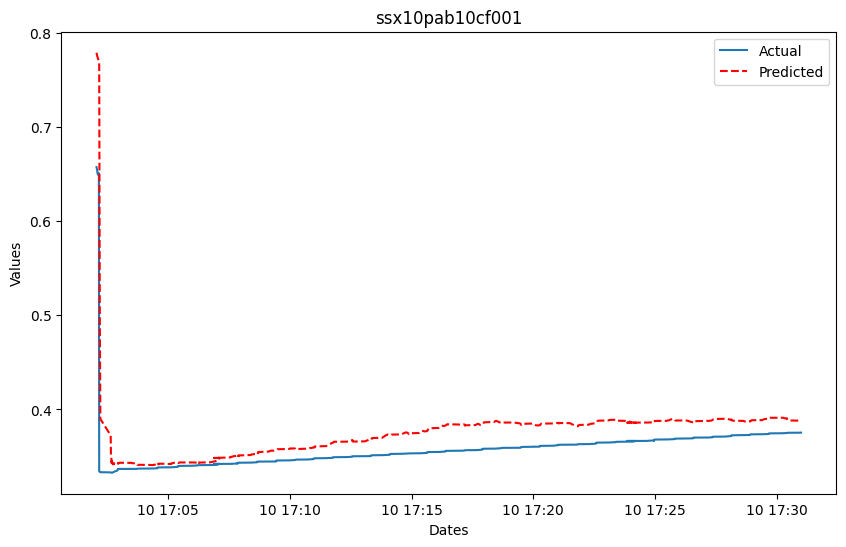

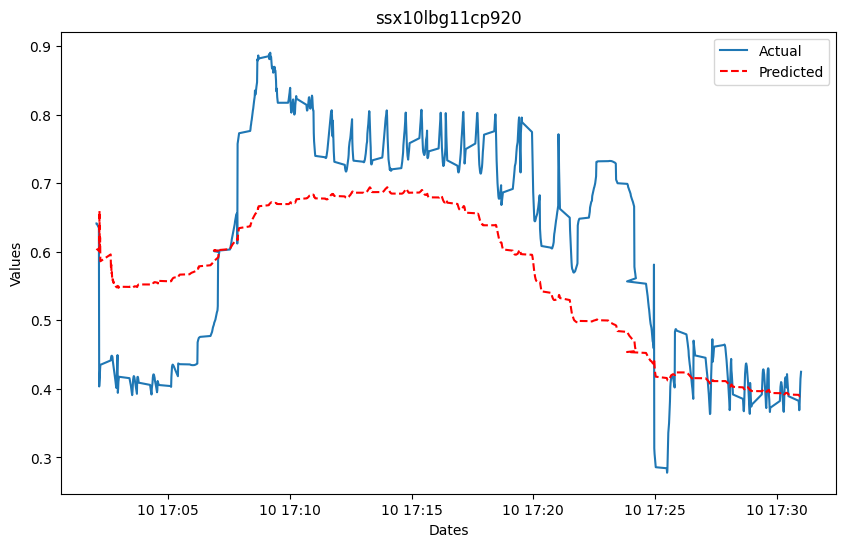

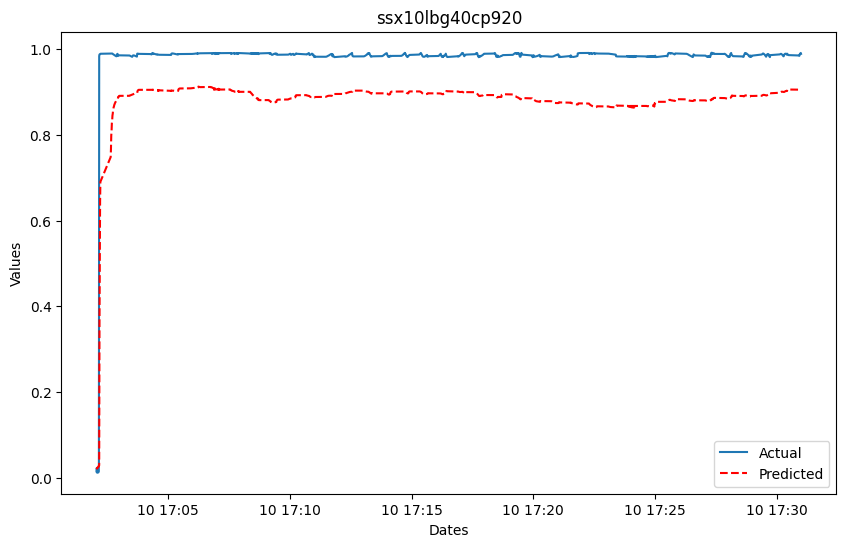

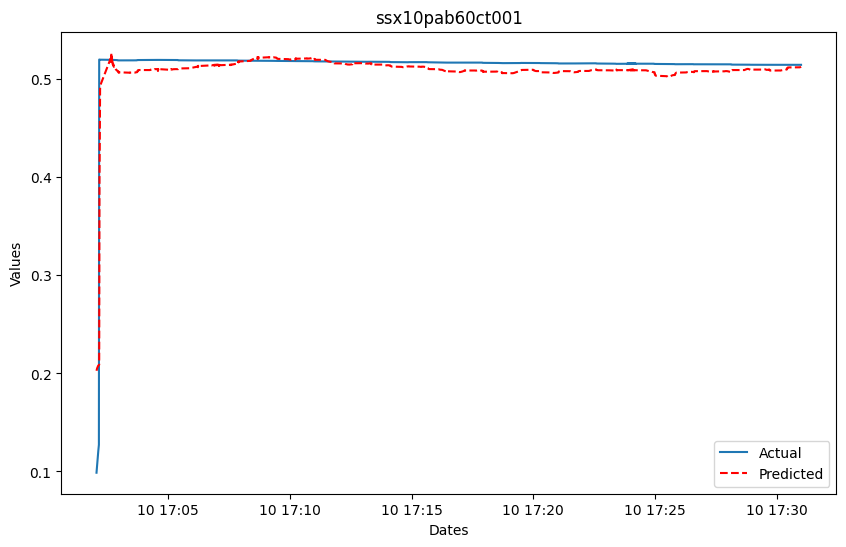

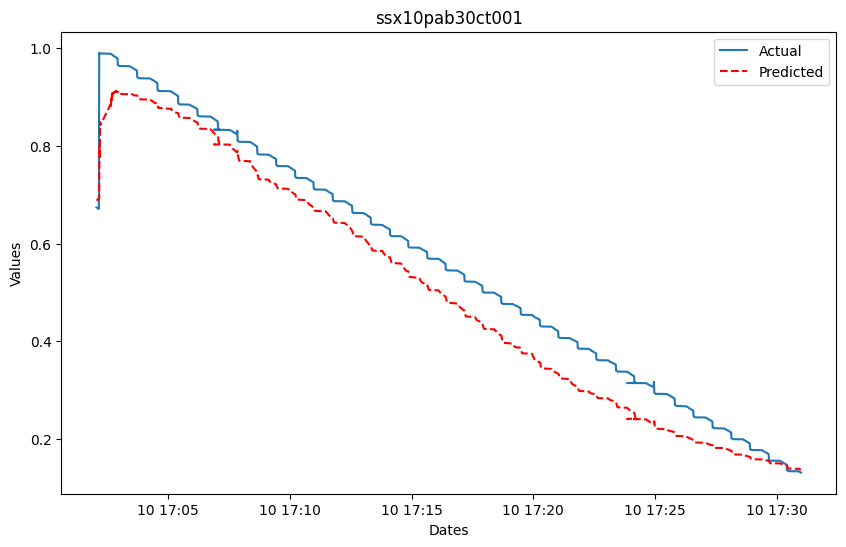

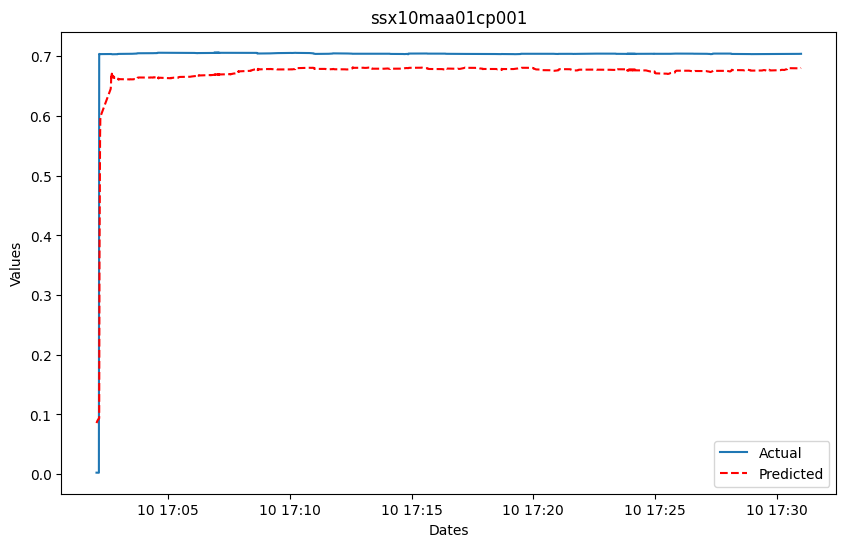

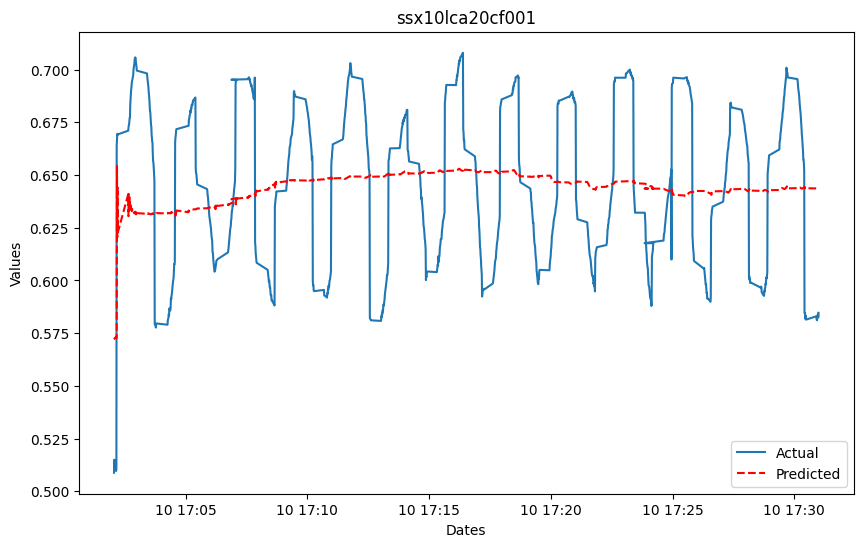

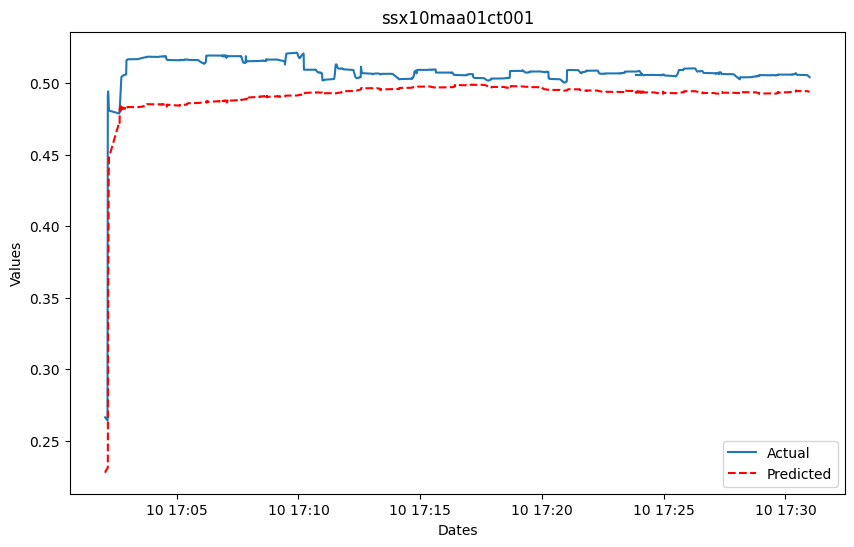

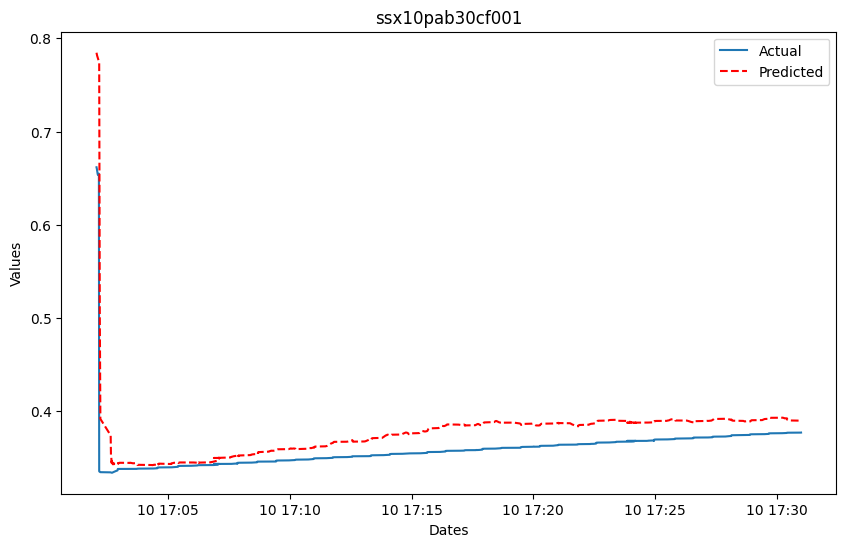

In [17]:
# Forecast Plot with Dates on X-axis
predicted_values = lstm_model.predict(X_test)

d_pred = pd.DataFrame(predicted_values[:, 0], columns=df.columns)
d_pred.index = date_time[-len(d_pred):]
d_test = pd.DataFrame(y_test[:, 0], columns=df.columns)
d_test.index = date_time[-len(d_test):]
sensors_names = list(df)[:14]

d_train = pd.DataFrame(y_train[:, 0], columns=df.columns)
d_train.index = date_time[-len(d_train):]

for ind, sensor in enumerate(sensors_names):
  fig, ax = plt.subplots(figsize=(10, 6))

  # Plot the actual values
  plt.plot(d_test[sensor], label='Actual')

  # Plot predicted values with a dashed line
  plt.plot(d_pred[sensor], label='Predicted', color='r', linestyle='--')


  plt.title(sensor)
  plt.xlabel('Dates')
  plt.ylabel('Values')
  ax.legend()
  


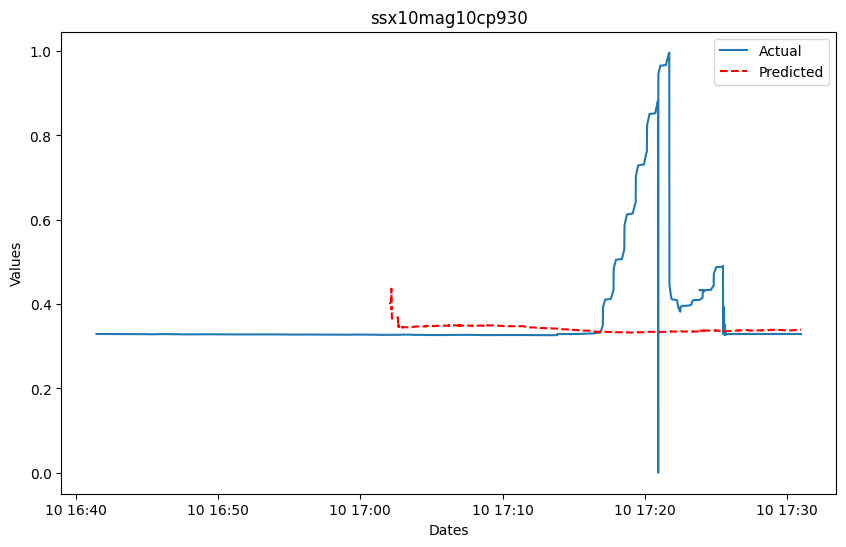

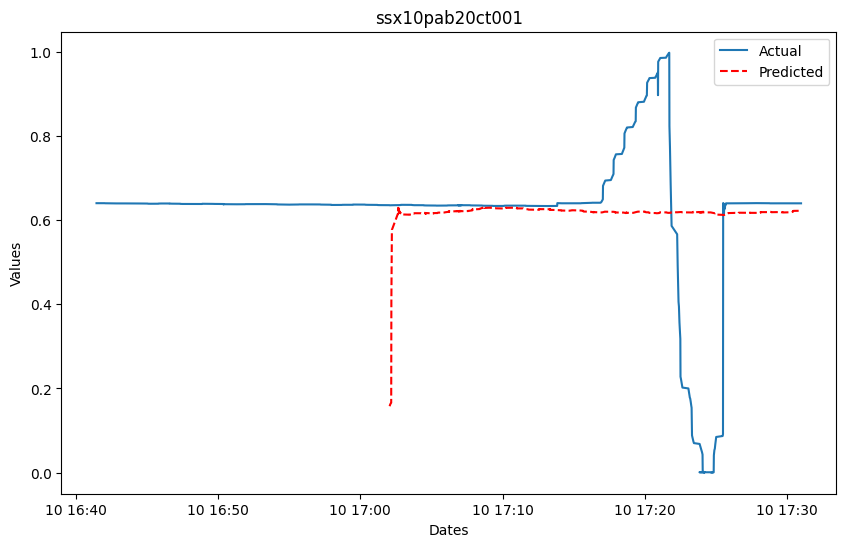

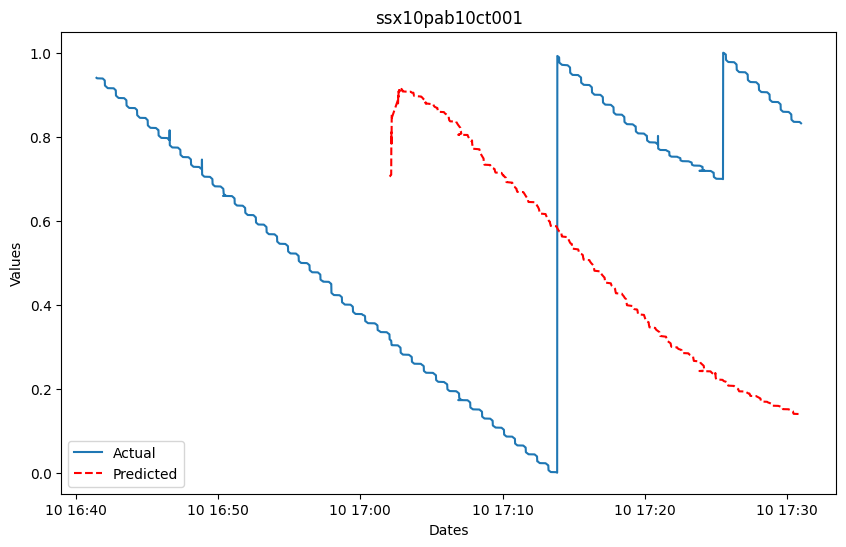

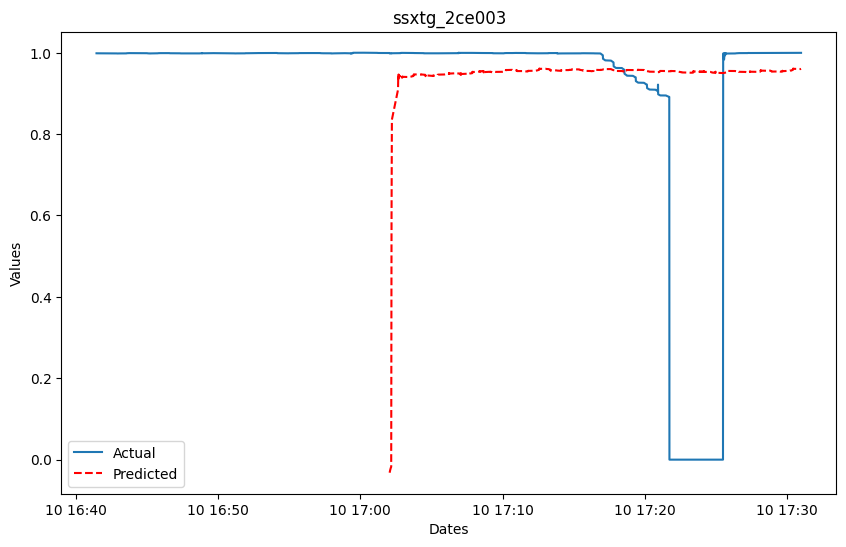

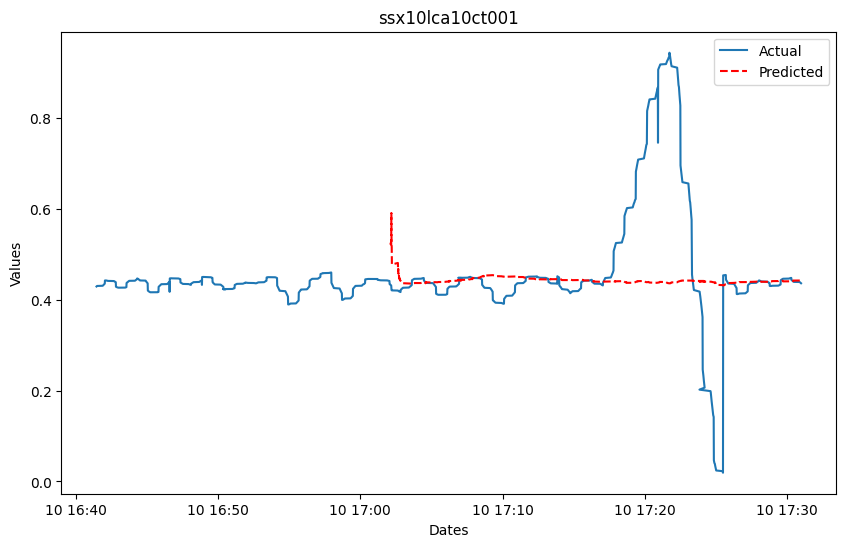

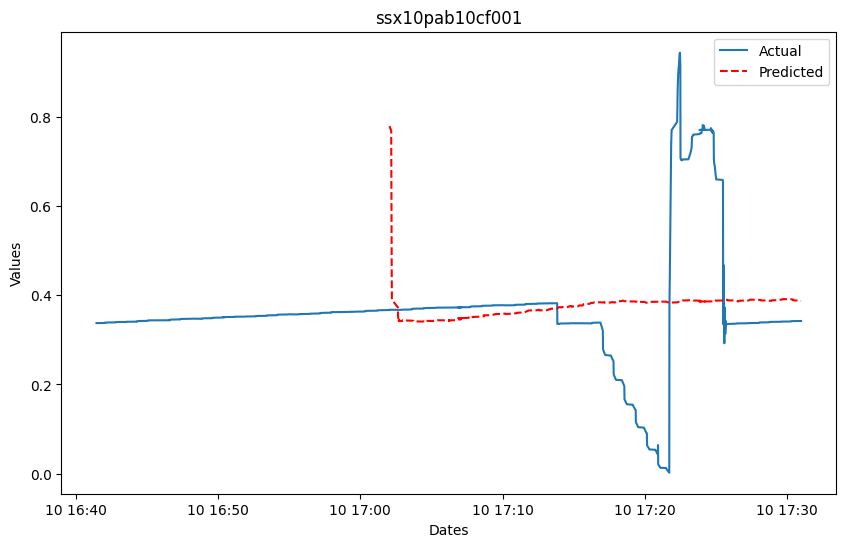

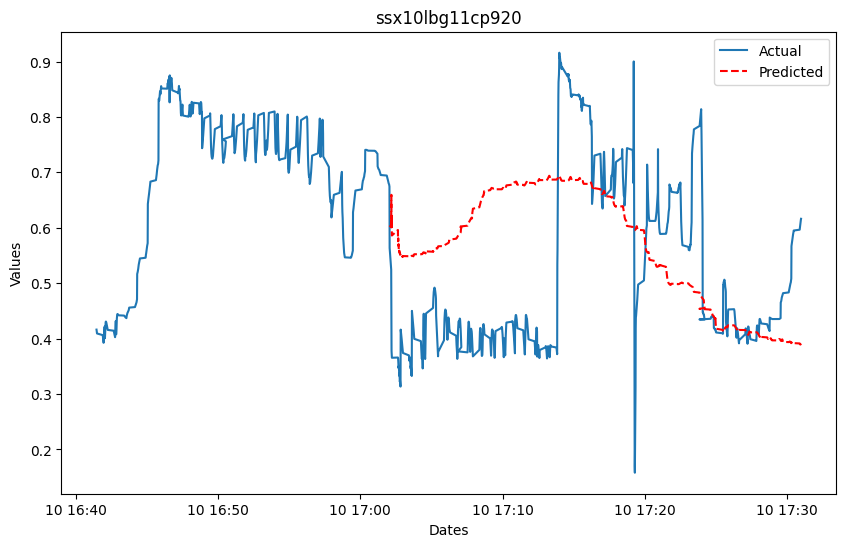

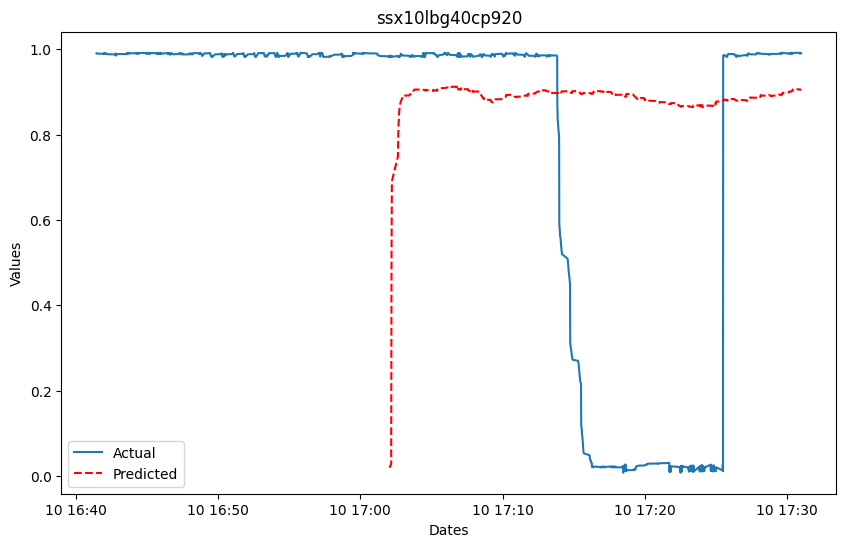

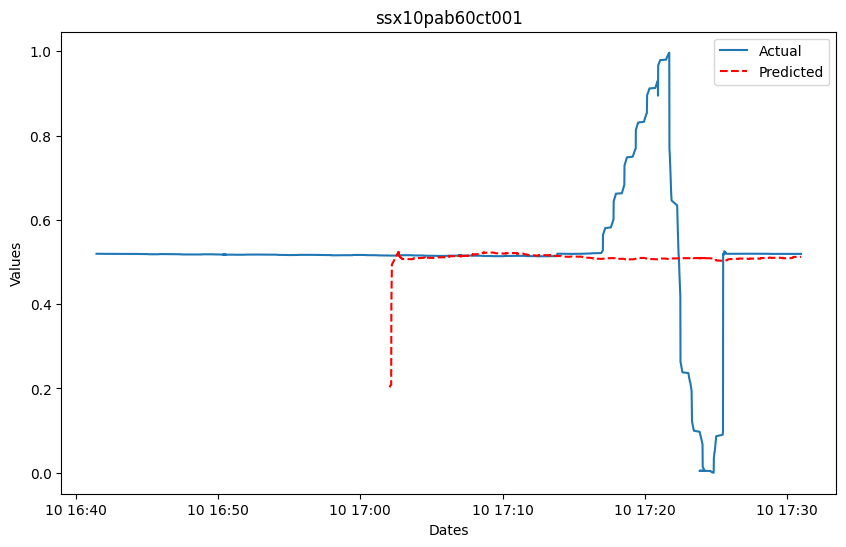

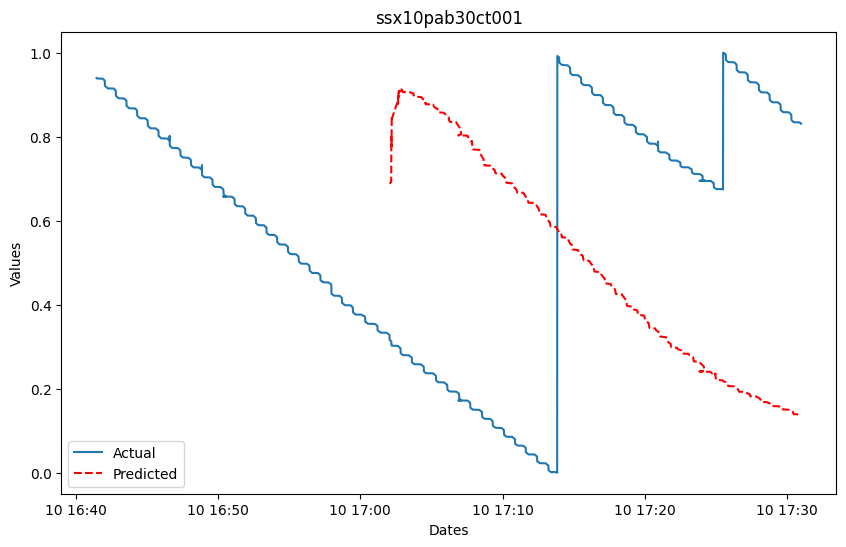

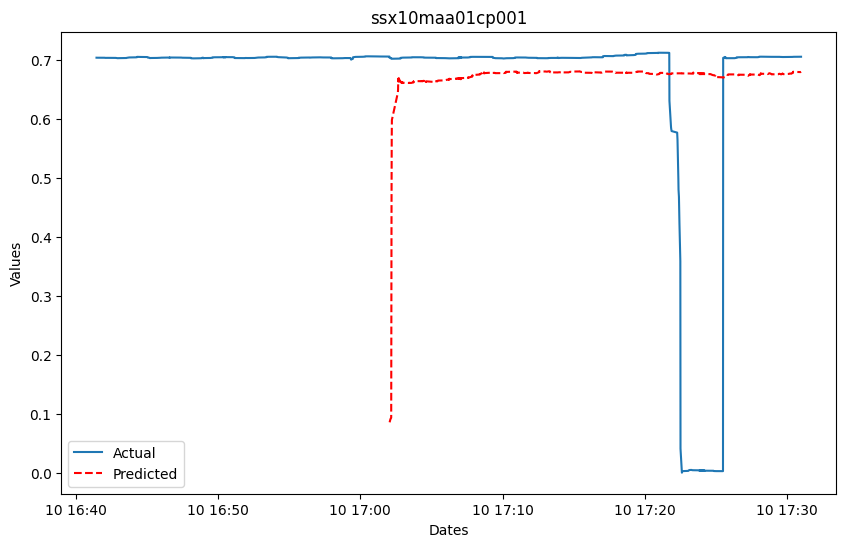

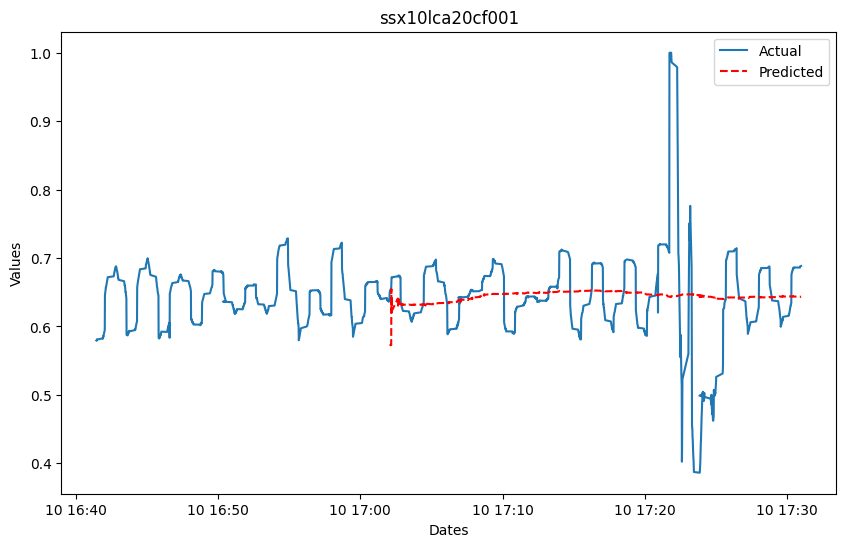

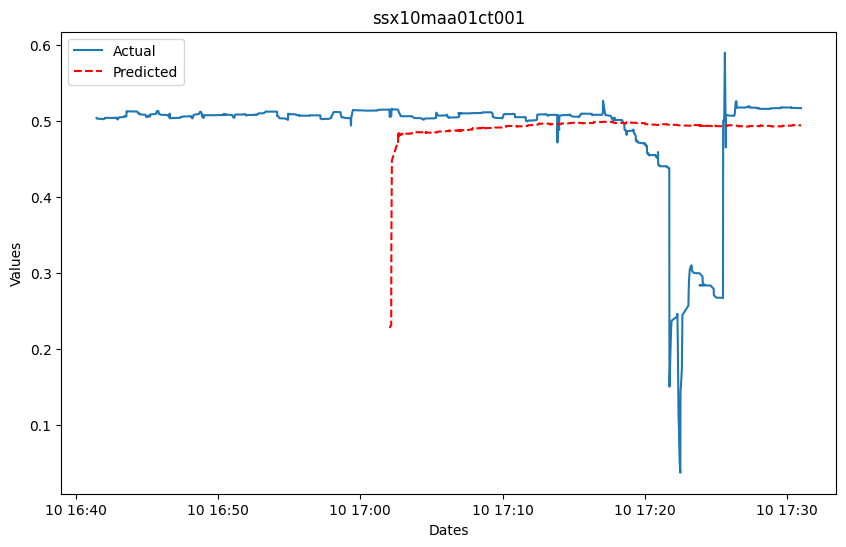

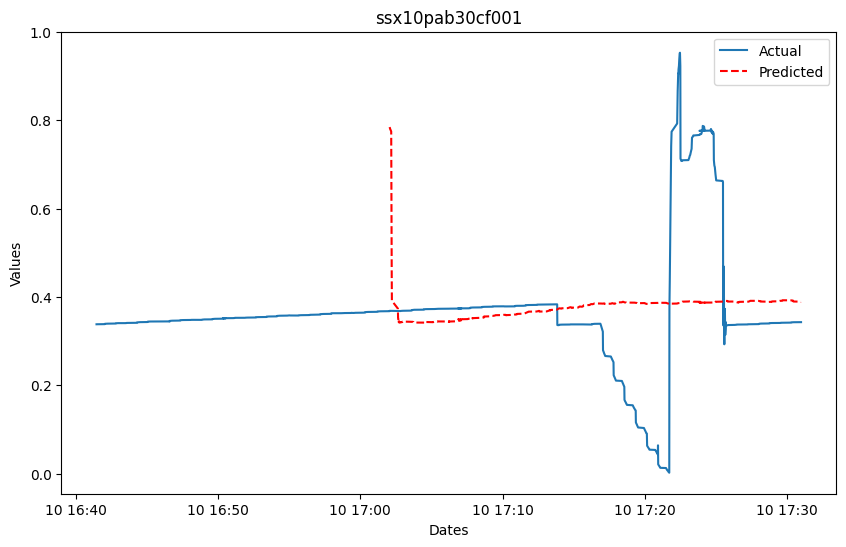

In [18]:
d_train = pd.DataFrame(y_train[:, 0], columns=df.columns)
d_train.index = date_time[-len(d_train):]

for ind, sensor in enumerate(sensors_names):
  fig, ax = plt.subplots(figsize=(10, 6))

  # Plot the actual values
  plt.plot(d_train[sensor], label='Actual')

  # Plot predicted values with a dashed line
  plt.plot(d_pred[sensor], label='Predicted', color='r', linestyle='--')


  plt.title(sensor)
  plt.xlabel('Dates')
  plt.ylabel('Values')
  ax.legend()


In [41]:
df = pd.read_csv('data_8_without_duplicates.csv')
#делим датасет на слайсы для построения релевантного графика
#df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M')
df = df[::]
#переводит в формат дататайм
df['DateTime'] = pd.to_datetime(df['DateTime'])

<Axes: xlabel='DateTime', ylabel='ssx10lbg11cp920'>

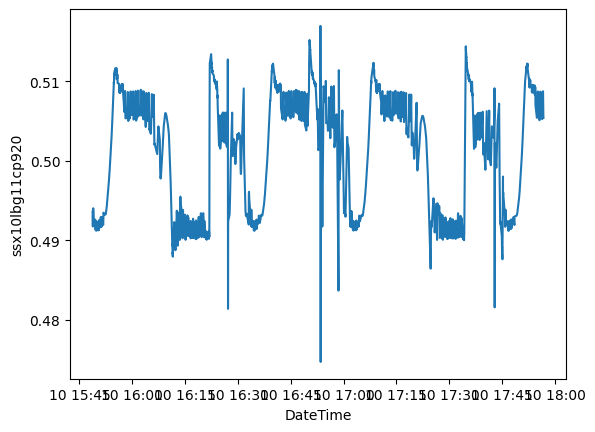

In [105]:
sns.lineplot(y=df['ssx10lbg11cp920'],x=df['DateTime'])

In [128]:
# Assuming you have a DataFrame 'df' with a 'DateTime' column
train = df[df['DateTime'].between(pd.to_datetime('2024-07-10 17:01:51'), pd.to_datetime('2024-07-10 17:37:56'), inclusive='both')]
#val = df[df['DateTime'].between(pd.to_datetime('2024-07-10 17:01:51'), pd.to_datetime('2024-07-10 17:15:15'), inclusive='both')] 
test = df[df['DateTime'].between(pd.to_datetime('2024-07-10 16:52:00'), pd.to_datetime('2024-07-10 17:14:50'), inclusive='both')] 

test

,ssx10mag10cp930,ssx10pab20ct001,ssx10pab10ct001,ssxtg_2ce003,ssx10lca10ct001,ssx10pab10cf001,ssx10lbg11cp920,ssx10lbg40cp920,ssx10pab60ct001,ssx10pab30ct001,ssx10maa01cp001,ssx10lca20cf001,ssx10maa01ct001,ssx10pab30cf001,DateTime
2495,10.282694,43.861747,30.320393,54.976306,44.931652,3495.045711,0.509711,99.658760,44.414935,29.828334,6.223705,193.143506,489.200134,3480.055391,2024-07-10 16:52:00.314909
2496,10.282880,43.861789,30.320359,54.974961,44.936659,3495.046268,0.509556,99.648578,44.414992,29.828291,6.223747,193.149506,489.199968,3480.055929,2024-07-10 16:52:01.039442
2497,10.282960,43.861944,30.320315,54.977733,44.943193,3495.046368,0.509365,99.635425,44.415111,29.828234,6.223637,193.370657,489.196731,3480.056036,2024-07-10 16:52:01.768608
2498,10.283117,43.862176,30.320276,54.974621,44.948778,3495.045666,0.509386,99.618609,44.415259,29.828184,6.223404,193.610813,489.194486,3480.055339,2024-07-10 16:52:02.490768
2499,10.283538,43.862461,30.320231,54.972393,44.955008,3495.045193,0.509556,99.612188,44.415448,29.828127,6.223300,194.432251,489.197493,3480.054891,2024-07-10 16:52:03.218823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3351,10.262150,43.822844,30.284199,55.006105,45.169017,3495.413056,0.506850,103.985455,44.375450,29.782067,6.226326,197.302801,489.198001,3480.417394,2024-07-10 17:14:46.327055
3352,10.262097,43.822823,30.284151,55.000964,45.170934,3495.413465,0.506410,103.981263,44.375467,29.782005,6.225998,197.548830,489.190191,3480.417800,2024-07-10 17:14:47.054291
3353,10.261985,43.822780,30.284119,54.999768,45.172068,3495.413999,0.506219,103.979398,44.375465,29.781965,6.225895,198.255363,489.191535,3480.418326,2024-07-10 17:14:47.792489
3354,10.261897,43.822709,30.284074,54.999819,45.173474,3495.414770,0.506064,103.978273,44.375454,29.781907,6.226041,198.266752,489.200482,3480.419087,2024-07-10 17:14:48.533207


In [129]:
# Columns to scale
variables = ['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001']

# Extract features
train_features = train[variables]
test_features = test[variables]
#val_features = val[variables]

# Standardize the features
scaler = MinMaxScaler()
scaler.fit(train_features)
#scaler.fit(val_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)
#val_features = scaler.transform(val_features)

# Replace scaled features in DataFrames
train.loc[:, variables] = train_features  # Use .loc to assign directly to the DataFrame
test.loc[:, variables] = test_features 
#val.loc[:, variables] = val_features

In [131]:
# Ensure consistent seq_size
seq_size = 10

def to_sequence(x, y, seq_size):
    x_values = []
    y_values = []

    for i in range(len(x) - seq_size):
        x_values.append(x.iloc[i:(i + seq_size)].values) 
        # Extract y values for the same sequence length
        y_values.append(y.iloc[i:(i + seq_size)].values)

    return np.array(x_values), np.array(y_values)


# Corrected column selection using a list
target_columns = ['ssx10mag10cp930', 'ssx10pab20ct001', 'ssx10pab10ct001', 'ssxtg_2ce003', 
                'ssx10lca10ct001', 'ssx10pab10cf001', 'ssx10lbg11cp920', 'ssx10lbg40cp920', 
                'ssx10pab60ct001', 'ssx10pab30ct001', 'ssx10maa01cp001', 'ssx10lca20cf001', 
                'ssx10maa01ct001', 'ssx10pab30cf001']

trainX, trainY = to_sequence(train[variables], train[target_columns], seq_size)
testX, testY = to_sequence(test[variables], test[target_columns], seq_size)
#valX,valY = to_sequence(test[variables], val[target_columns], seq_size)

len(testX)

851

In [7]:
seq_size = trainX.shape[1]

model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Компиляция модели с указанием оптимизатора
#model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 14)         │         1,806 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,606 (807.05 KB)

 Trainable params: 206,606 (807.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.2850 - val_loss: 0.1609
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1145 - val_loss: 0.1193
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0795 - val_loss: 0.1102
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0673 - val_loss: 0.1036
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0611 - val_loss: 0.1059
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0554 - val_loss: 0.1033
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0530 - val_loss: 0.1024
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0493 - val_loss: 0.1038
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0477 - val_loss: 0.1022
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0457 - val_loss: 0.1017


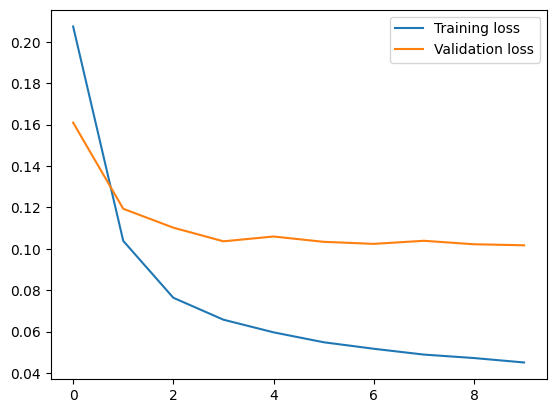

In [8]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Length of testMAE: 851


(851, 14)

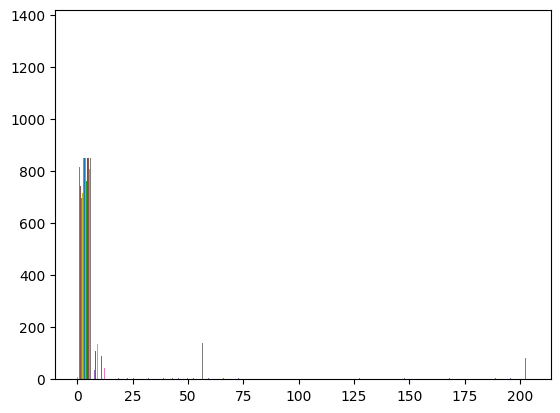

In [132]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 0.3  #or Define 90% value of max as threshold.

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)
print(f"Length of testMAE: {len(testMAE)}")
testMAE.shape

In [193]:
print(f"Length of testMAE: {len(testMAE)}")
print(f"Shape of testMAE: {testMAE.shape}") 

Length of testMAE: 345
Shape of testMAE: (345, 14)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


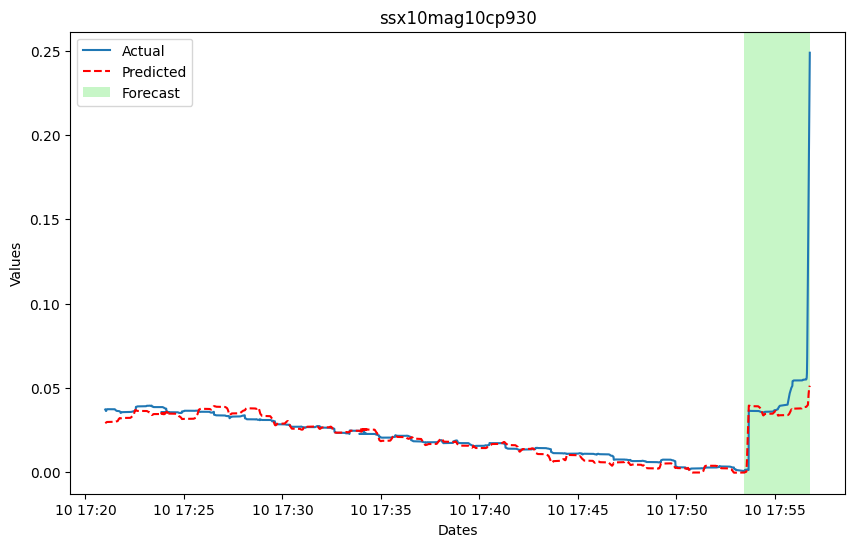

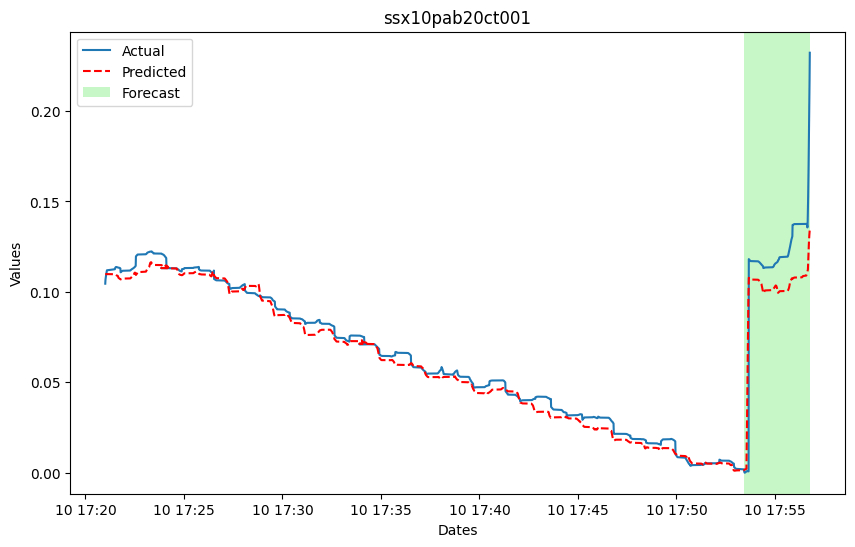

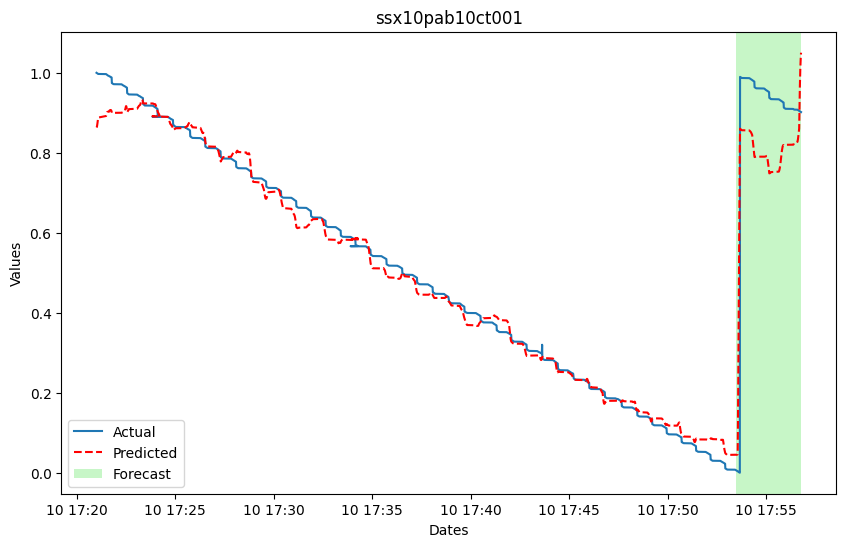

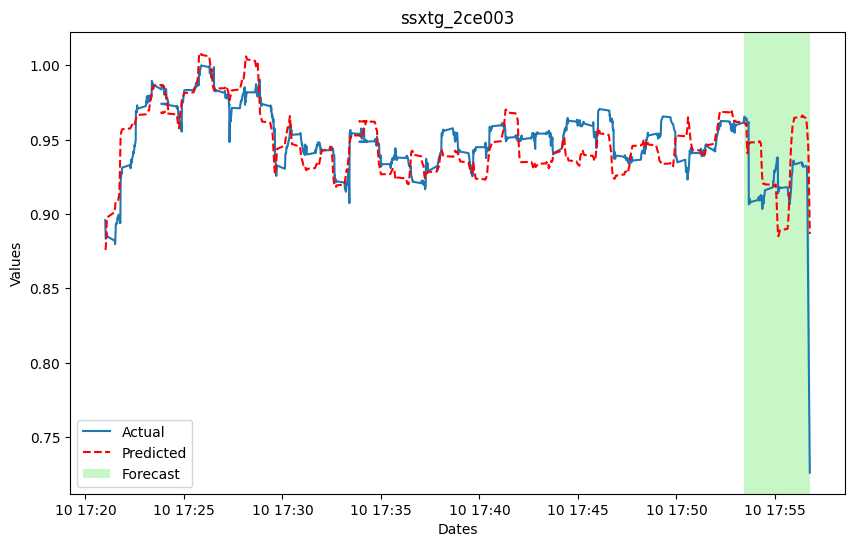

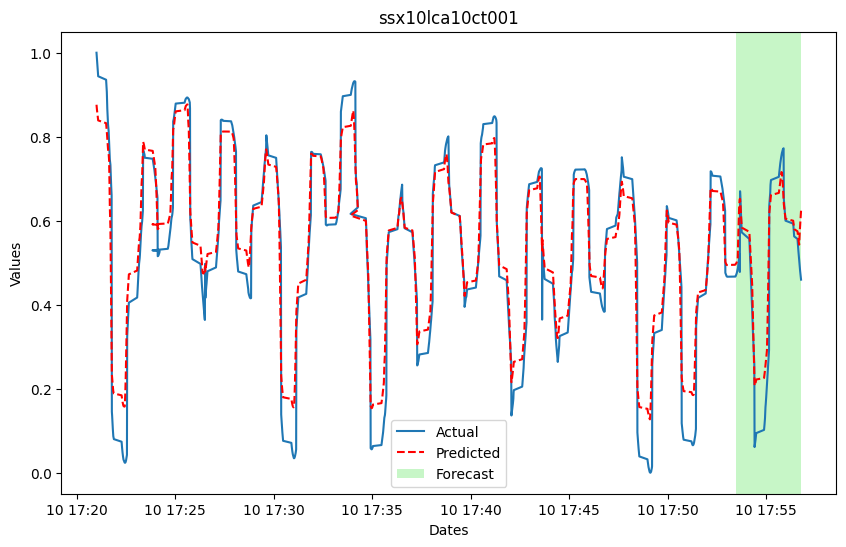

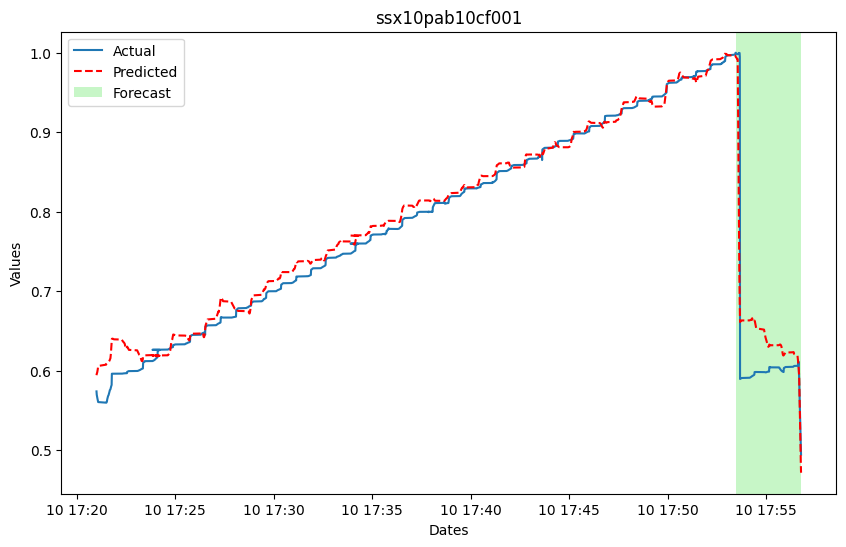

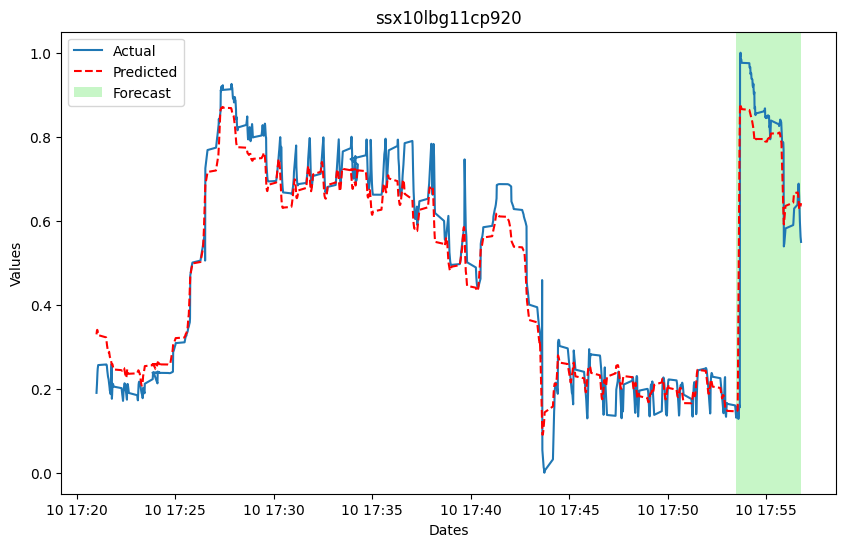

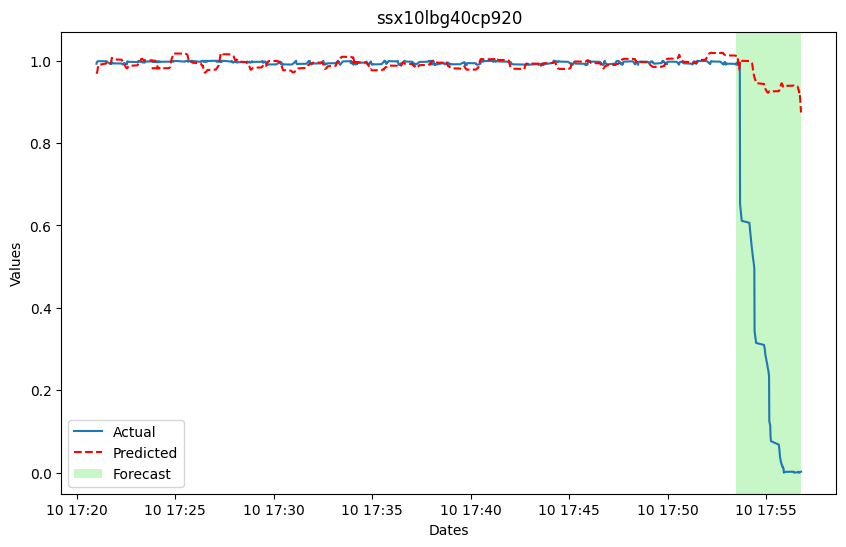

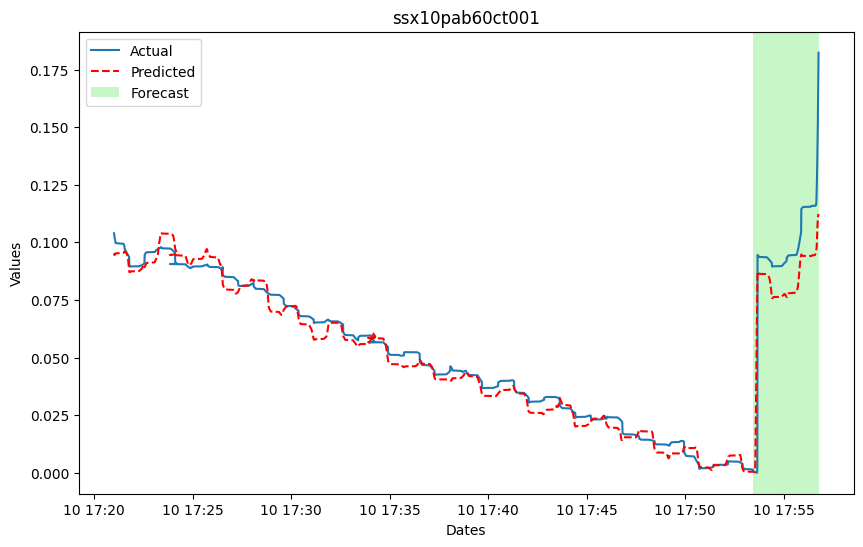

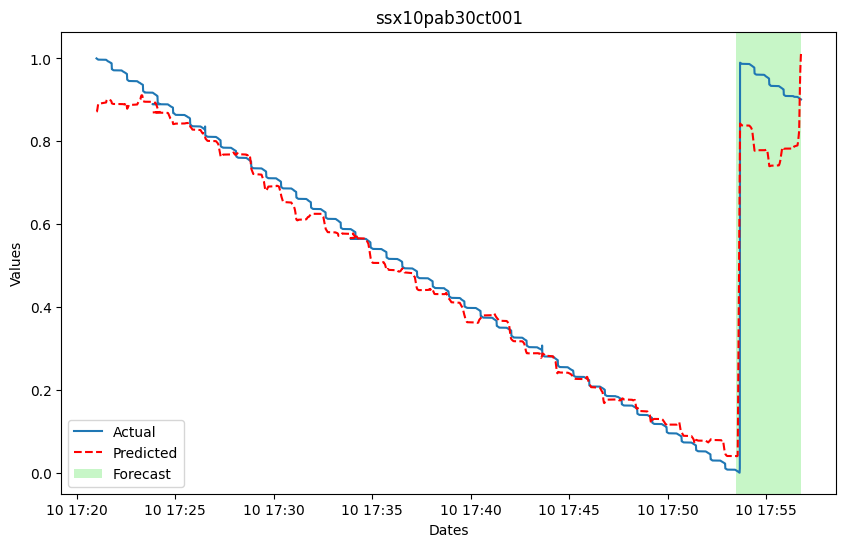

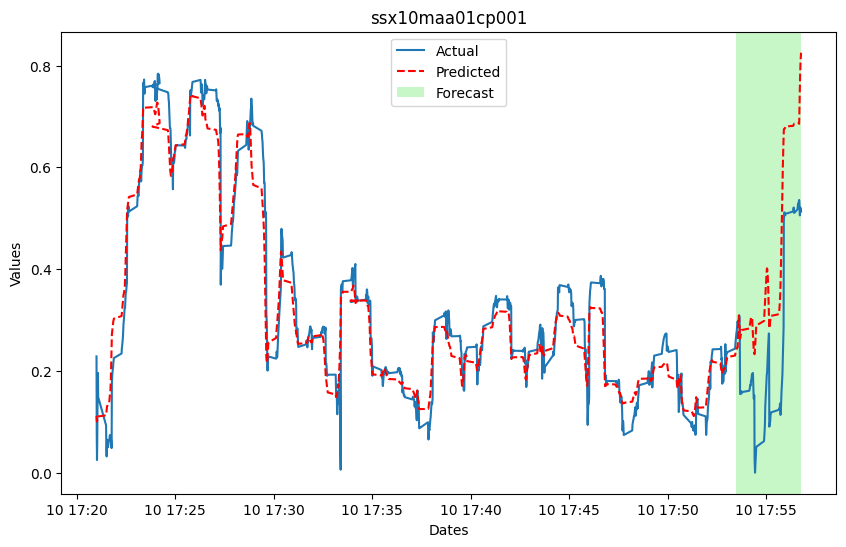

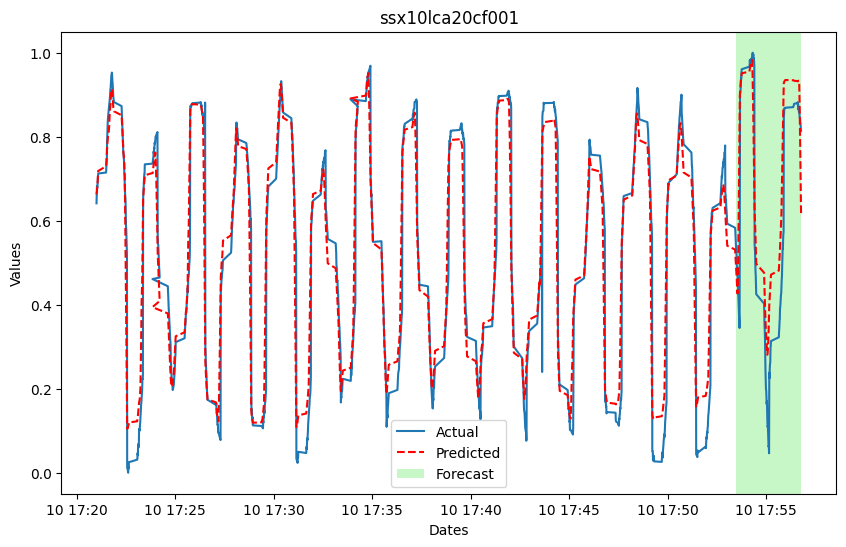

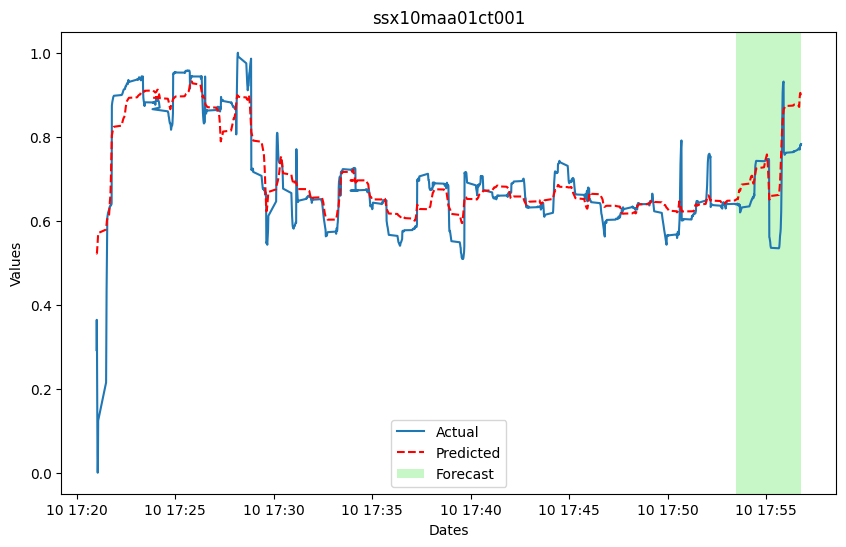

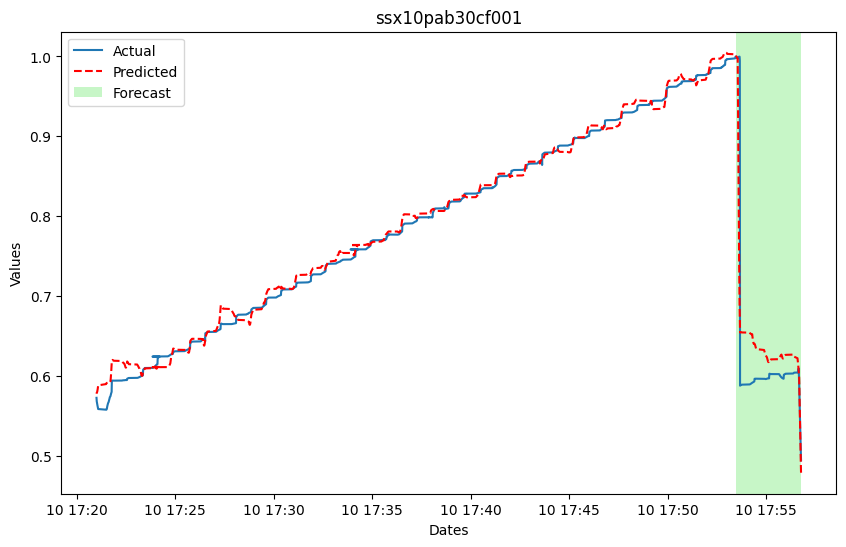

In [35]:
trainPredict = model.predict(trainX)
d_pred = pd.DataFrame(trainPredict[:, 0], columns=df.columns)
d_pred.index = date_time[-len(d_pred):]
d_test = pd.DataFrame(trainY[:, 0], columns=df.columns)
d_test.index = date_time[-len(d_test):]
sensors_names = list(df)[:14]

for ind, sensor in enumerate(sensors_names):
  fig, ax = plt.subplots(figsize=(10, 6))

  # Plot the actual values
  plt.plot(d_test[sensor], label='Actual')

  # Plot predicted values with a dashed line
  plt.plot(d_pred[sensor], label='Predicted', color='r', linestyle='--')

  # Highlight the forecasted portion with a different color
  plt.axvspan(d_test.index[int(len(d_test) * 0.9)], d_test.index[len(d_test) - 1], facecolor='lightgreen', alpha=0.5, label='Forecast')

  plt.title(sensor)
  plt.xlabel('Dates')
  plt.ylabel('Values')
  ax.legend()


  

In [54]:
test.shape

(355, 15)

float

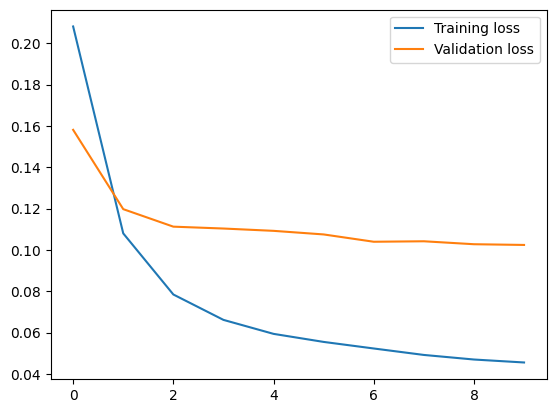

In [194]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
type(max_trainMAE)

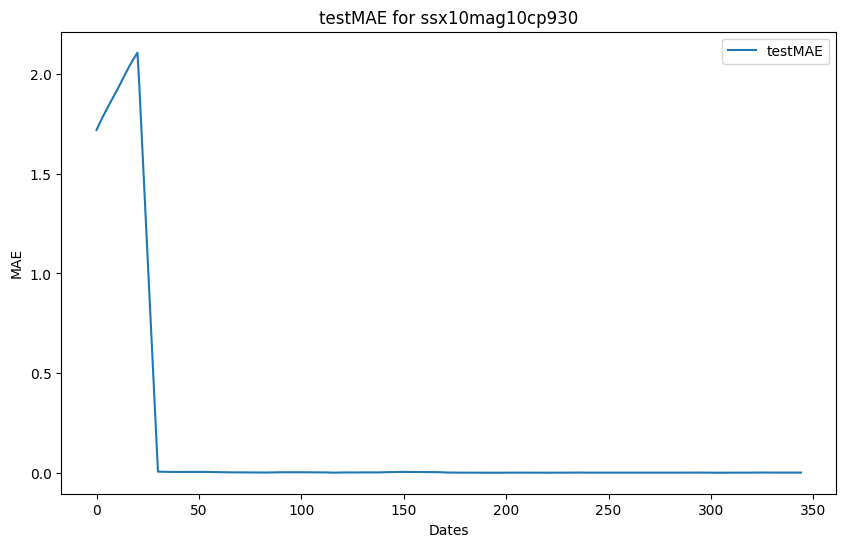

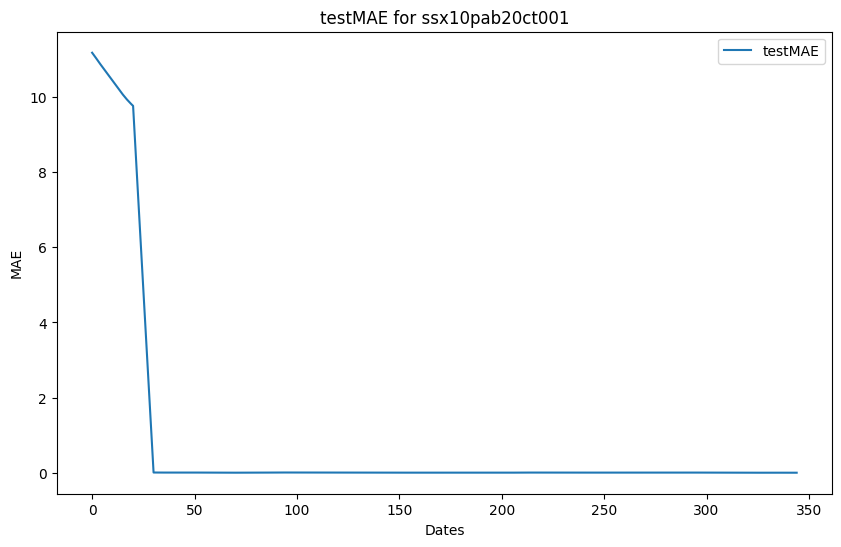

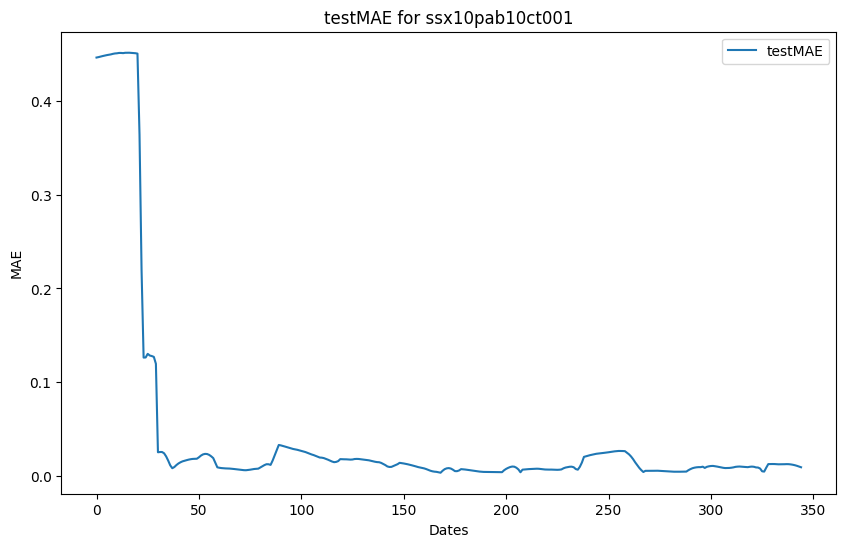

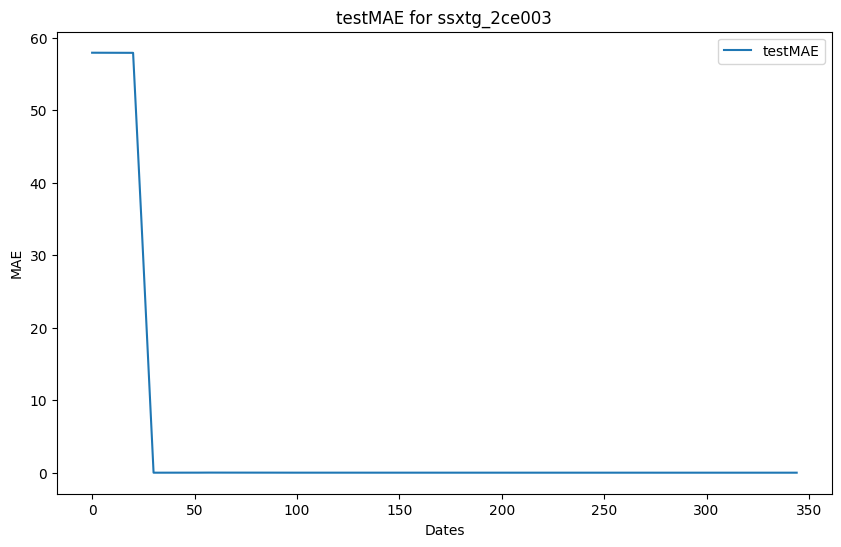

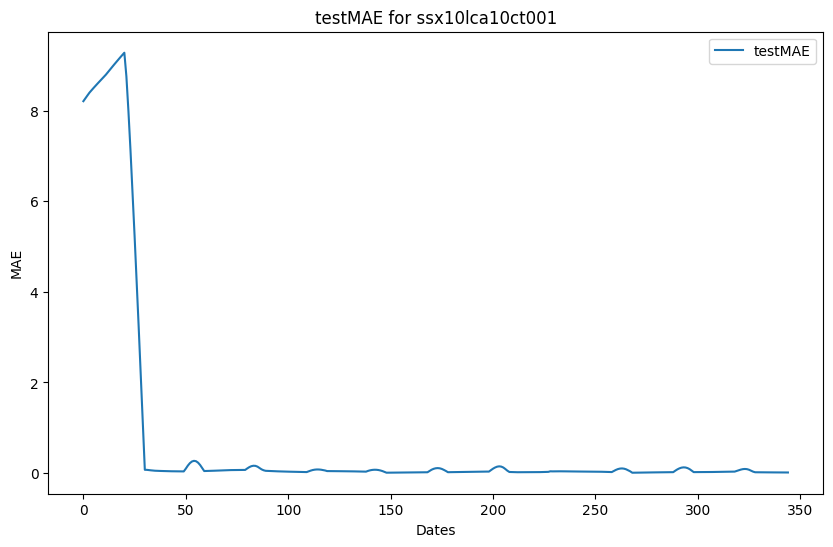

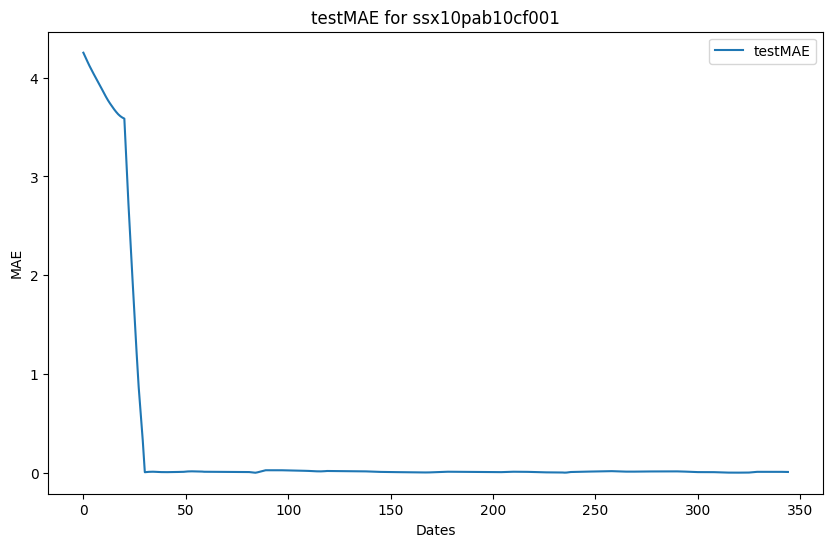

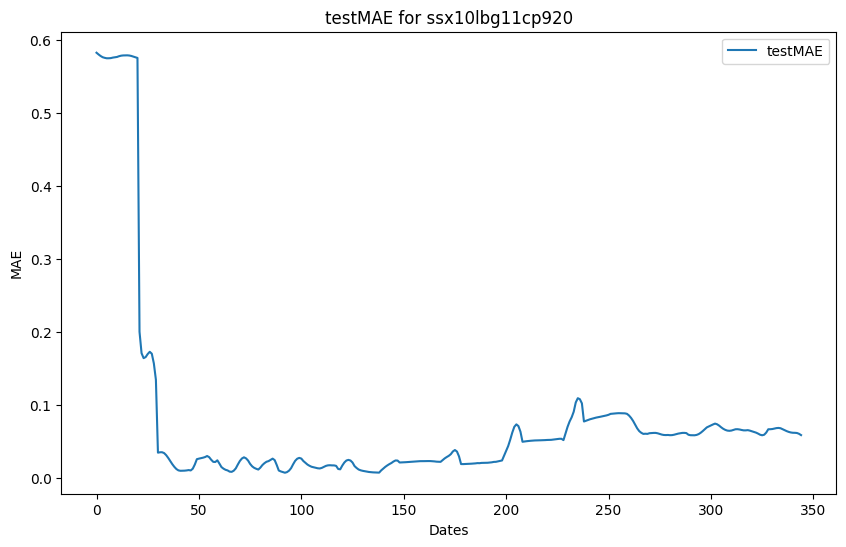

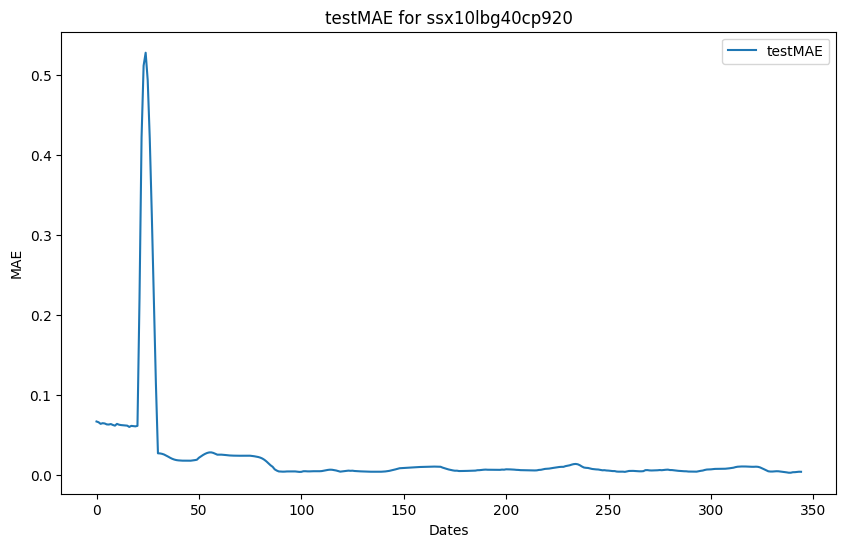

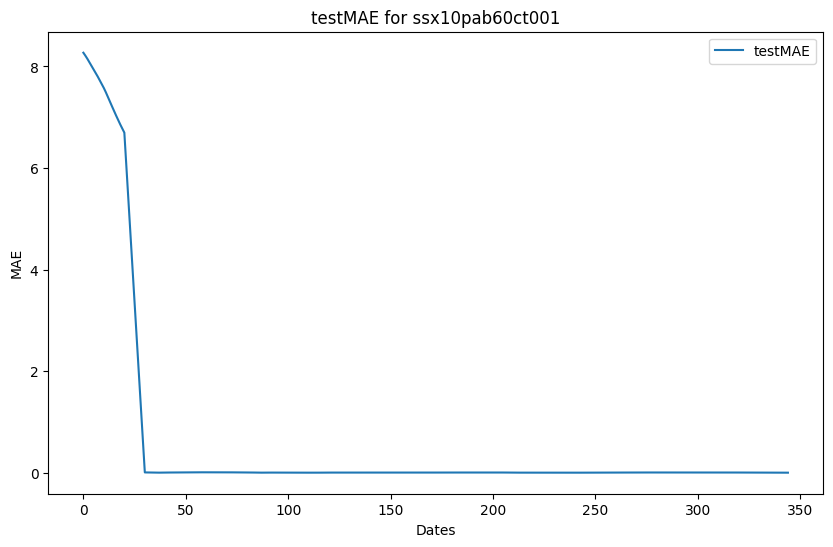

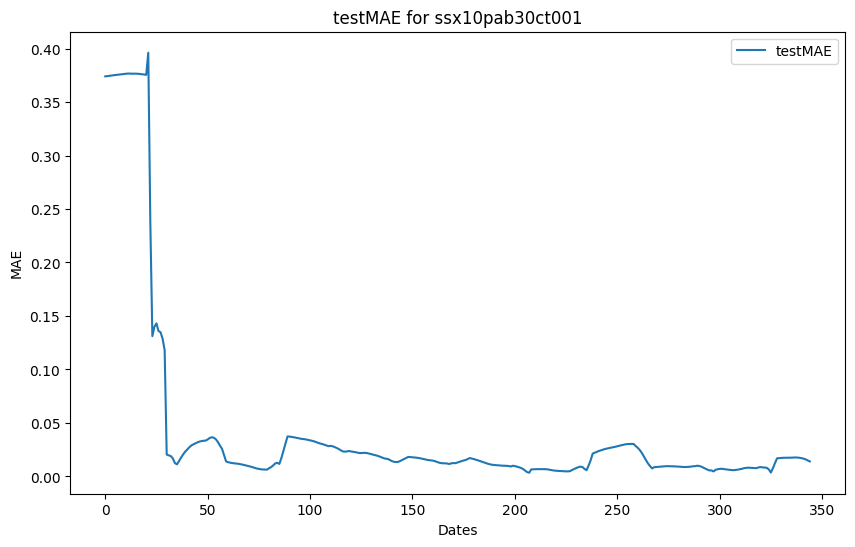

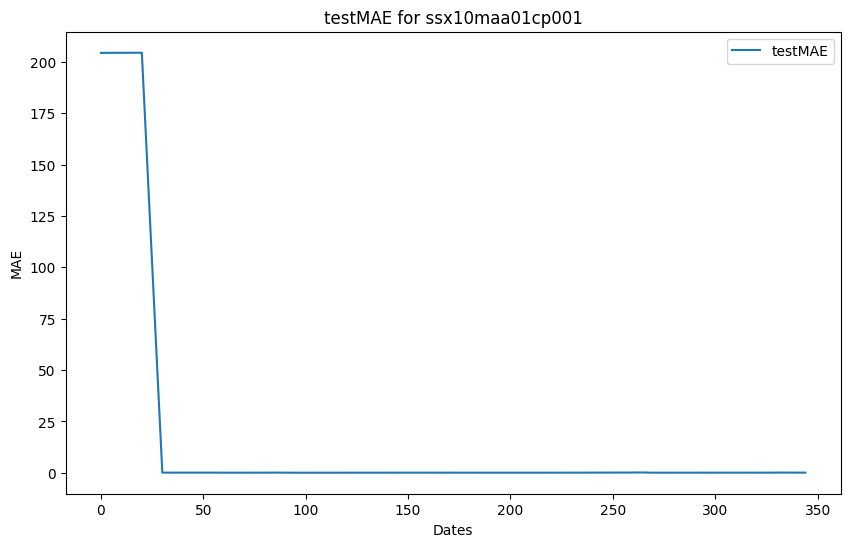

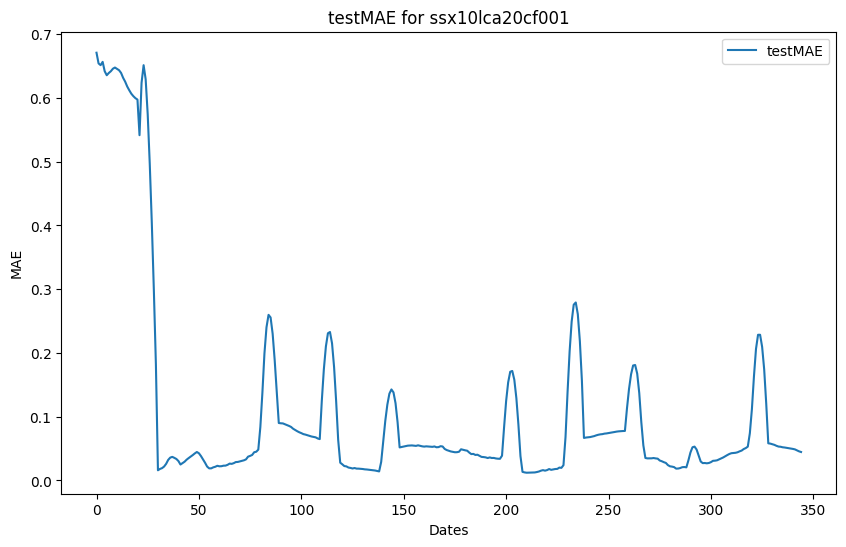

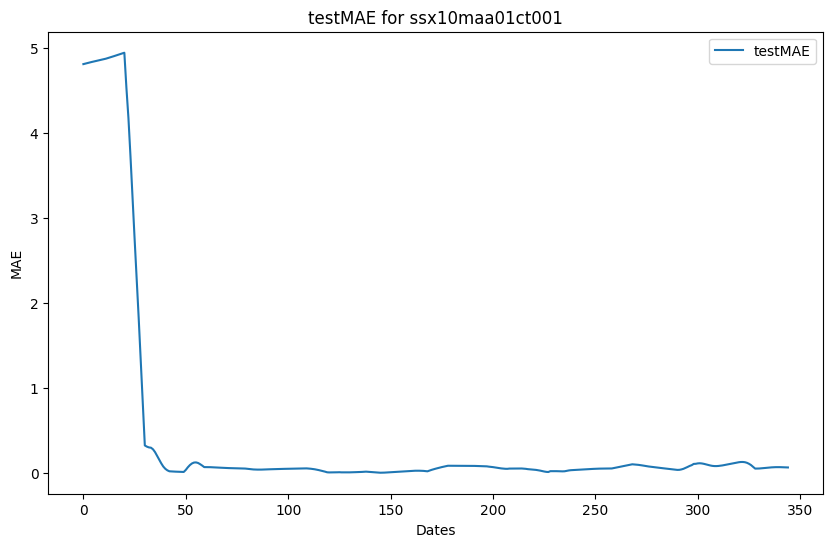

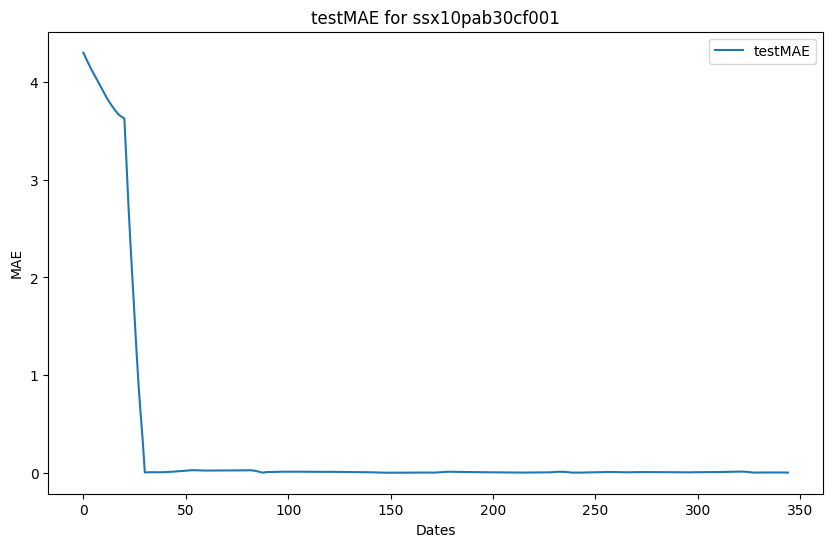

In [13]:

# Capture all details in a DataFrame for easy plotting

testX = np.reshape(testX, (testX.shape[0], -1))
anomaly_df= pd.DataFrame(testX)
anomaly_dfTESTMAE = pd.DataFrame(testMAE)
#anomaly_dfMAXTRAINMAE= pd.DataFrame(max_trainMAE)
#anomaly_df= anomaly_dfTESTMAE > anomaly_dfMAXTRAINMAE

# Создайте отдельные столбцы для каждой переменной в DataFrame
for ind, sensor in enumerate(variables):
  anomaly_dfTESTMAE[sensor] = testMAE[:, ind]

# Нарисуйте графики testMAE для каждой переменной
for sensor in variables:
  fig, ax = plt.subplots(figsize=(10, 6))

  sns.lineplot(x=anomaly_df.index, y=anomaly_dfTESTMAE[sensor], label='testMAE', ax=ax)
  plt.title(f'testMAE for {sensor}')
  plt.xlabel('Dates')
  plt.ylabel('MAE')
  ax.legend()




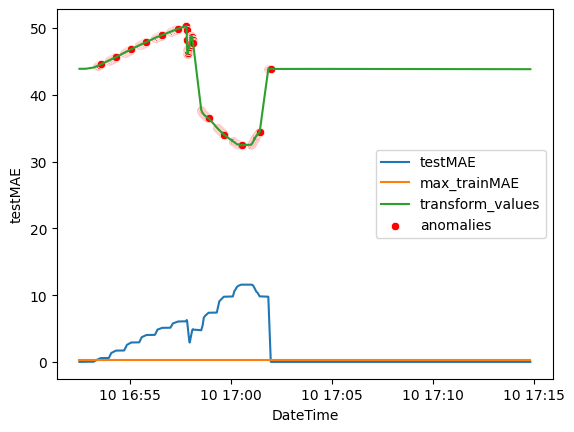

In [135]:
variables = ['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001']


anomaly_df = pd.DataFrame(test['ssx10pab20ct001'].iloc[seq_size:], columns=['ssx10pab20ct001'])
ssx10mag10cp930_df = pd.DataFrame(test['ssx10pab20ct001'].iloc[seq_size:])
ssx10mag10cp930_df.columns = ['ssx10pab20ct001']

test_numeric = test.drop(columns=['DateTime'])
test_inverse = scaler.inverse_transform(test_numeric)

#test_for_anomaly = scaler.inverse_transform(test)

# Преобразование столбца testMAE из testMAE в список
testMAE_values = testMAE[:, 1].tolist()
# Добавление столбца testMAE в anomaly_df
anomaly_df['testMAE'] = testMAE_values
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['ssx10pab20ct001'] = test[seq_size:]['ssx10pab20ct001']
anomaly_df['DateTime'] = test[seq_size:]['DateTime']
test_inverse = test_inverse[seq_size:, 1].tolist()
anomaly_df['transform_values'] = test_inverse
#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['DateTime'], y=anomaly_df['testMAE'], label='testMAE')
sns.lineplot(x=anomaly_df['DateTime'], y=anomaly_df['max_trainMAE'], label='max_trainMAE')

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

#Plot anomalies
sns.lineplot(x=anomaly_df['DateTime'], y=anomaly_df['transform_values'], label='transform_values')

#Plot anomalies as scatter plot
sns.scatterplot(x=anomalies['DateTime'], y=anomalies['transform_values'], color='r', label='anomalies')

# Добавление легенды
plt.legend()

plt.show()


In [149]:
df = pd.read_csv('testloc.csv')
new_columns = ['need_control', 'incr_suction', 'check_BROY', 'check_GTU_KU', 'seal_sys_low_press', 'low_steam', 'check_ejectors', 'low_OK_flow_rate', 'hight_cv_temp', 'check_circ_sys', 'need_run_sso']

for column in new_columns:
    df[column] = np.zeros(len(df))


# Условные операторы для добавления классификации возможных ошибок по признакам
df.loc[(df['ssx10mag10cp930']-df['ssx10mag10cp930'].shift()>1)& \
       (df['need_control'].shift()==1),'need_control'] = 1

df.loc[(df['ssx10mag10cp930'] > df['ssx10mag10cp930'].shift())& \
       (np.absolute(df['ssx10maa01cp001'] - df['ssx10maa01cp001'].shift())<0.1) & \
        (np.absolute(df['ssx10maa01ct001'] - df['ssx10maa01ct001'].shift())<5) & \
        (np.absolute(df['ssx10lbg40cp920'] - df['ssx10lbg40cp920'].shift())<2) & \
        (np.absolute(df['ssx10lca10ct001'] - df['ssx10lca10ct001'].shift())<1) & \
        (np.absolute(df['ssx10lbg11cp920'] - df['ssx10lbg11cp920'].shift())<0.05) & \
        (np.absolute(df['ssx10lca20cf001'] - df['ssx10lca20cf001'].shift())<30) & \
        (np.absolute(df['ssx10pab10cf001'] - df['ssx10pab10cf001'].shift())<300) & \
        (np.absolute(df['ssx10pab30cf001'] - df['ssx10pab30cf001'].shift())<300) & \
        (np.absolute(df['ssx10pab10ct001'] - df['ssx10pab10ct001'].shift())<2) & \
        (np.absolute(df['ssx10pab30ct001'] - df['ssx10pab30ct001'].shift())<2) & \
        (np.absolute(df['ssx10pab20ct001'] - df['ssx10pab20ct001'].shift())<2) & \
        (np.absolute(df['ssx10pab60ct001'] - df['ssx10pab60ct001'].shift())<2), 'incr_suction'] = 1

# Добавление столбца 'check_BROY' для указания потенциальных проблем с BROY
df.loc[(df['need_control']) & (df['ssx10maa01cp001']<=5.9), 'check_BROY'] = 1

# Добавление столбца 'check_GTU_KU' для указания потенциальных проблем с GTU_KU
df.loc[(df['need_control']) & (df['ssx10maa01ct001']>=527) & \
(df['ssx10maa01ct001']>df['ssx10maa01ct001'].shift()) & \
(df['ssx10maa01ct001'].shift()> df['ssx10maa01ct001'].shift(periods=2)),
'check_GTU_KU']  = 1

# Добавление столбца 'seal_sys_low_press' для указания потенциальных проблем с низким давлением в системе уплотнений
df.loc[(df['need_control']) & (df['ssx10lbg40cp920'] <= 100),
       'seal_sys_low_press'] = 1

# Добавление столбца 'low_steam' для указания потенциальных проблем с низким давлением пара
df.loc[(df['need_control']) & \
        (df['ssx10mag10cp930'].shift() - df['ssx10mag10cp930'] > 1) & \
       (df['ssx10lca10ct001'] >=50),'low_steam' ] = 1

# Добавление столбца 'check_ejectors' для указания потенциальных проблем с эжекторами
df.loc[(df['need_control']) & (df['ssx10lbg11cp920'] <= 0.3), 'check_ejectors'] = 1

# Добавление столбца 'low_OK_flow_rate' для указания потенциальных проблем с низким расходом кислорода
df.loc[(df['need_control']) & (df['ssx10lca20cf001'] <=100), 'low_OK_flow_rate'] = 1

# Добавление столбца 'check_circ_sys' для указания потенциальных проблем с системой циркуляции
df.loc[(df['need_control']) & (df['ssx10pab10cf001'].shift() - df['ssx10pab10cf001'] > 500) & \
       (df['ssx10pab30cf001'].shift() - df['10pab30cf001'] > 500) , 'check_circ_sys'] = 1

# Добавление столбца 'hight_cv_temp' для указания потенциальных проблем с высокой температурой нагнетания
df.loc[(df['need_control']) & \
       (df['ssx10pab10ct001'].shift() - df['ssx10pab10ct001'] >=2) & \
       (df['ssx10pab30ct001'].shift() - df['ssx10pab30ct001'] >=2) & \
       (df['ssx10pab10cf001'].shift() - df['ssx10pab10cf001'] <=300) & \
       (df['ssx10pab30cf001'].shift() - df['ssx10pab30cf001'] <=300),'hight_cv_temp'] = 1

# Добавление столбца 'need_run_sso' для указания потенциальной необходимости запуска ССО
df.loc[(df['need_control']) & \
       (df['ssx10pab20ct001'].shift() - df['ssx10pab20ct001'] >=2) & \
       (df['ssx10pab60ct001'].shift() - df['ssx10pab60ct001'] >=2) & \
       (df['ssx10pab10cf001'].shift() - df['ssx10pab10cf001'] <=300) & \
       (df['ssx10pab30cf001'].shift() - df['ssx10pab30cf001'] <=300), 'need_run_sso'] = 1

TypeError: unsupported operand type(s) for &: 'float' and 'bool'

In [148]:
df['ssx10mag10cp930']

0       10.283541
1       10.287829
2       10.286168
3       10.285182
4       10.285811
          ...    
4957    10.248748
4958    10.248399
4959    10.247963
4960    10.247523
4961    10.247162
Name: ssx10mag10cp930, Length: 4962, dtype: float64